
===== SUMMARY =====
Total trials: 144
Completed trials: 144
Best FID overall: 4.3956

===== PER DATABASE BEST =====

DB: sqlite:///fid_optimization_1.db
  Best trial: 29
  Best FID: 4.4173
  a: None
  b: None
  constraint: None

DB: sqlite:///fid_optimization_2.db
  Best trial: 26
  Best FID: 4.3956
  a: None
  b: None
  constraint: None

DB: sqlite:///fid_optimization.db
  Best trial: 55
  Best FID: 4.4007
  a: 1.2301447284240619
  b: -4.0853689331499385
  constraint: -0.39493474787775235


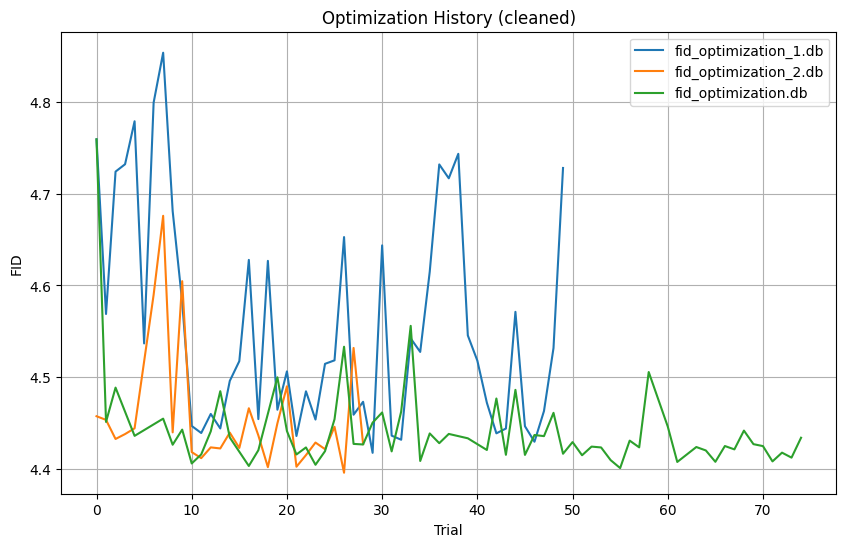

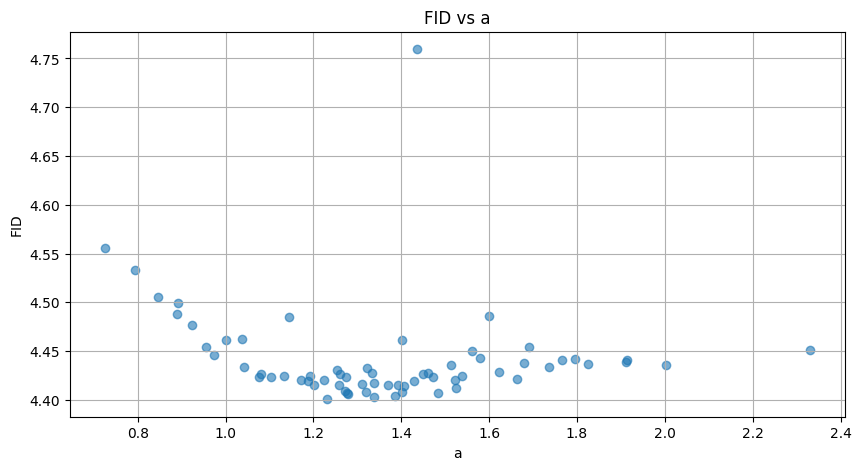

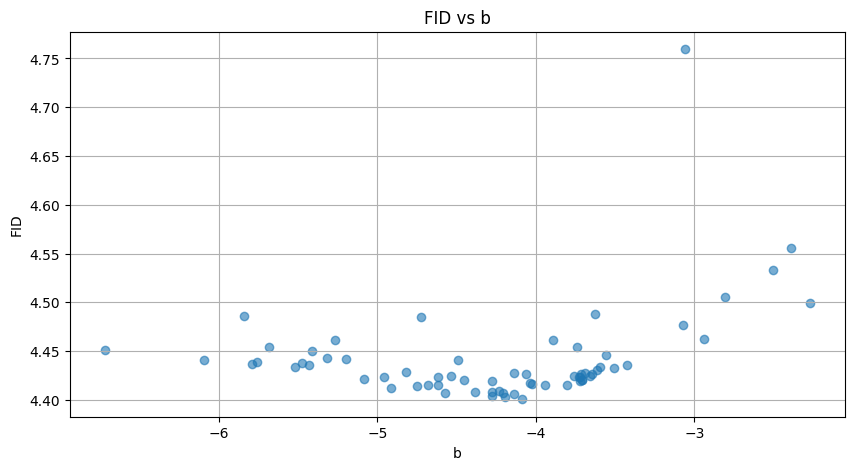


===== Parameter importance: sqlite:///fid_optimization_1.db =====

===== Parameter importance: sqlite:///fid_optimization_2.db =====
a: 1.0000

===== Parameter importance: sqlite:///fid_optimization.db =====
constraint: 0.6519
a: 0.3481

Merged CSV saved as merged_trials.csv
Plots saved in current directory.


In [3]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import os

DBS = [
    "sqlite:///fid_optimization_1.db",
    "sqlite:///fid_optimization_2.db",
    "sqlite:///fid_optimization.db",
]

STUDY_NAME = "diffusion_fid_optimization"

def load_study_dataframe(db_path):
    study = optuna.load_study(study_name=STUDY_NAME, storage=db_path)
    df = study.trials_dataframe(attrs=("number", "value", "state", "params", "user_attrs"))
    df["source_db"] = os.path.basename(db_path)
    return study, df


all_dfs = []
studies = []

for db in DBS:
    study, df = load_study_dataframe(db)
    studies.append(study)
    all_dfs.append(df)

merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df = merged_df[merged_df["value"] < 999].copy()


# Save merged CSV
# merged_df.to_csv("merged_trials.csv", index=False)

print("\n===== SUMMARY =====")
print(f"Total trials: {len(merged_df)}")
print(f"Completed trials: {(merged_df['state'] == 'COMPLETE').sum()}")
print(f"Best FID overall: {merged_df['value'].min():.4f}")

print("\n===== PER DATABASE BEST =====")
for db, study in zip(DBS, studies):
    best = study.best_trial
    print(f"\nDB: {db}")
    print(f"  Best trial: {best.number}")
    print(f"  Best FID: {best.value:.4f}")
    print(f"  a: {best.user_attrs.get('a')}")
    print(f"  b: {best.user_attrs.get('b')}")
    print(f"  constraint: {best.user_attrs.get('constraint_value')}")


# ---------- Plot optimization history ----------

plt.figure(figsize=(10, 6))

for df, db in zip(all_dfs, DBS):
    df_complete = df[
        (df["state"] == "COMPLETE") &
        (df["value"] < 999)
    ]
    plt.plot(df_complete["number"], df_complete["value"], label=os.path.basename(db))

plt.xlabel("Trial")
plt.ylabel("FID")
plt.title("Optimization History (cleaned)")
plt.legend()
plt.grid()
plt.savefig("optimization_history.png")
plt.show()



# ---------- Parameter scatter plots ----------

plt.figure(figsize=(10, 5))
plt.scatter(merged_df["user_attrs_a"], merged_df["value"], alpha=0.6)
plt.xlabel("a")
plt.ylabel("FID")
plt.title("FID vs a")
plt.grid()
plt.savefig("fid_vs_a.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(merged_df["user_attrs_b"], merged_df["value"], alpha=0.6)
plt.xlabel("b")
plt.ylabel("FID")
plt.title("FID vs b")
plt.grid()
plt.savefig("fid_vs_b.png")
plt.show()


# ---------- Parameter importance (per study) ----------

for db, study in zip(DBS, studies):
    print(f"\n===== Parameter importance: {db} =====")
    importance = optuna.importance.get_param_importances(study)
    for k, v in importance.items():
        print(f"{k}: {v:.4f}")

print("\nMerged CSV saved as merged_trials.csv")
print("Plots saved in current directory.")


In [8]:
import optuna
import math

DBS = [
    "sqlite:///fid_optimization.db",
    "sqlite:///fid_optimization_1.db",
    "sqlite:///fid_optimization_2.db",
]

STUDY_NAME = "diffusion_fid_optimization"

targets = [
    ([0.0168169338469557, 0.0575429182802859, 0.1968960260143427, 0.6737239997353861], 9.84473411152397),
    ([0.0150565765163528, 0.0573856337276224, 0.2187157854074077, 0.8335987890877504], 9.723708410188832),
    ([0.0139210542980094, 0.0557095339234981, 0.2229394486606637, 0.8921632307563885], 9.571101753360923),
    ([0.0159631598274761, 0.0573198447019583, 0.2058216939607056, 0.7390559050730826], 9.717421789876106),
    ([0.0148802078120299, 0.0533830113237393, 0.1915125066792815, 0.6870545386088324], 9.639184201278692),
]

TOL = 1e-6

def match(w1, w2):
    return all(math.isclose(a, b, rel_tol=TOL, abs_tol=TOL) for a, b in zip(w1, w2))

print("\n a        b        cifar_fid     imagenet_fid")
print("-" * 50)

for weights_target, imagenet_fid in targets:
    found = False

    for db in DBS:
        study = optuna.load_study(study_name=STUDY_NAME, storage=db)

        for trial in study.trials:
            if trial.state.name != "COMPLETE":
                continue

            weights = trial.user_attrs.get("weights")
            if not weights:
                continue

            if match(weights, weights_target):
                a = trial.user_attrs.get("a")
                b = trial.user_attrs.get("b")
                cifar_fid = trial.value

                print(f"{a:.6f}  {b:.6f}  {cifar_fid:.6f}  {imagenet_fid:.6f}")
                found = True
                break

        if found:
            break

    if not found:
        print("NOT FOUND for weights:", weights_target)



 a        b        cifar_fid     imagenet_fid
--------------------------------------------------
1.230145  -4.085369  4.400661  9.844734
1.337979  -4.195940  4.402952  9.723708
1.386749  -4.274353  4.404274  9.571102
1.278363  -4.137472  4.405699  9.717422
1.277461  -4.207723  4.407353  9.639184


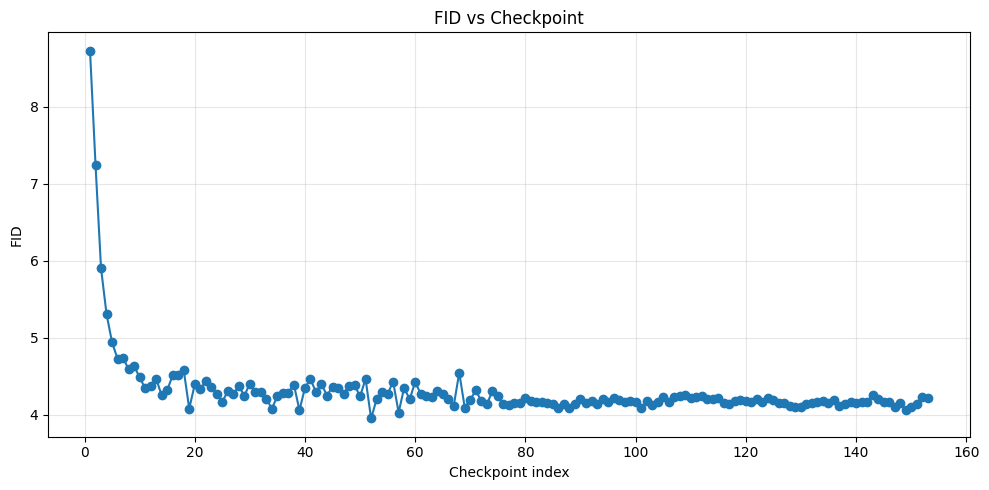

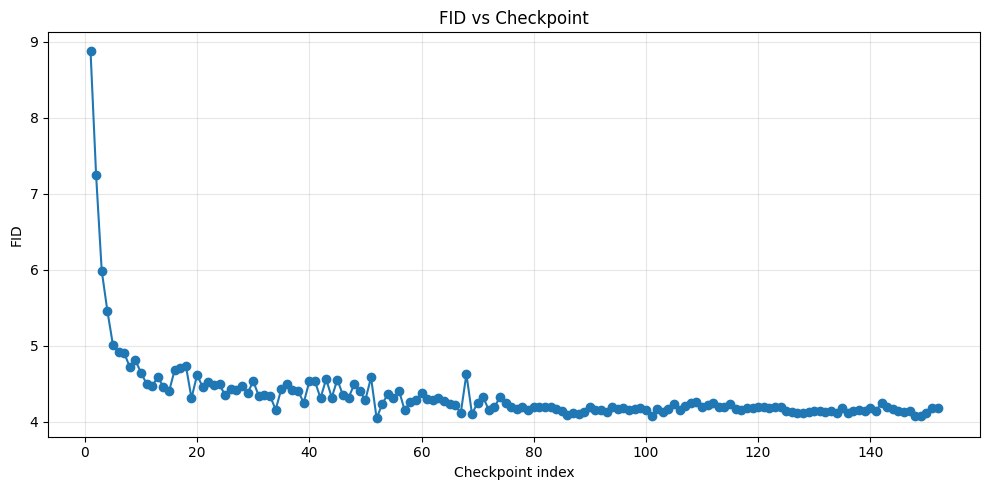

In [12]:
text ="""
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_30 98.72957413775778
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_60 51.20498134074231
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_90 11.11540826650204
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_120 8.483731443109217
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_150 8.72929000931404
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_180 7.240118253483136
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_210 5.900959833460119
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_240 5.306120608100018
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_270 4.941243559457417
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_300 4.725289223135522
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_330 4.738556532877959
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_360 4.590915267173864
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_390 4.6334761257316694
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_420 4.486959844491659
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_450 4.344655174450058
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_480 4.379810203092934
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_510 4.469214306240642
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_540 4.251287192276292
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_570 4.320605168864496
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_600 4.5109730769591865
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_630 4.518600075066937
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_660 4.581949988483596
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_690 4.079109853354274
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_720 4.3936632950956245
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_750 4.338266209968914
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_780 4.435343778292775
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_810 4.357624142864246
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_840 4.275627921184235
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_870 4.168987122339841
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_900 4.3078079526473445
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_930 4.267526548621534
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_960 4.376147155814863
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_990 4.246016403300676
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1020 4.406390082518729
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1050 4.293618117823095
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1080 4.291281102591452
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1110 4.206487271393974
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1140 4.079326383221854
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1170 4.24427680249864
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1200 4.283109999527898
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1230 4.289382373014366
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1260 4.391178796498017
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1290 4.059005460486491
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1320 4.348804725663504
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1350 4.466728089606145
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1380 4.2909411282888525
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1410 4.402161725810764
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1440 4.247922751581161
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1470 4.366161313389763
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1500 4.347608125212907
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1530 4.27112774137972
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1560 4.380054036618936
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1590 4.388118438659977
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1620 4.238314949198479
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1650 4.4667007443557
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1680 3.9540438864462106
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1710 4.1988644023305115
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1740 4.296717549242592
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1770 4.270266285079273
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1800 4.4312399512709115
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1830 4.029572022228711
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1860 4.351137826256817
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1890 4.200966795568669
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1920 4.42546388748702
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1950 4.2748667961123
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1980 4.2459276125172
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2010 4.226601606738423
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2040 4.310725604391148
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2070 4.271418426198263
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2100 4.204610084162127
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2130 4.118649977728968
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2160 4.547448627511465
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2190 4.0925482260657
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2220 4.197505597632123
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2250 4.317376225219878
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2280 4.179351816847387
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2310 4.135406208519276
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2340 4.3071454240757925
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2370 4.239725707684548
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2400 4.138815813587057
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2430 4.12712716461876
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2460 4.152249018429079
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2490 4.1496573189303465
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2520 4.22334919976971
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2550 4.173539537838885
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2580 4.162016824080979
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2610 4.162708338949097
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2640 4.1505852797770935
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2670 4.137287668750164
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2700 4.091697871445037
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2730 4.139359346260498
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2760 4.094392004862875
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2790 4.138591790381376
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2820 4.208579137706595
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2850 4.151115914924471
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2880 4.178146232931071
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2910 4.135904079632448
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2940 4.209240843292974
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2970 4.1648653865623295
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3000 4.2215968349160296
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3030 4.188840880678264
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3060 4.172147369232462
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3090 4.173651880400452
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3120 4.167521987963524
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3150 4.088964737008617
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3180 4.181791714734173
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3210 4.12754614378858
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3240 4.167771083332524
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3270 4.2338114875660615
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3300 4.168670971195564
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3330 4.235437539425745
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3360 4.2422861388300035
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3390 4.2620111380561685
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3420 4.217027328233427
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3450 4.225635262812715
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3480 4.2444880491907915
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3510 4.200375694441959
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3540 4.206179846935263
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3570 4.215471246430121
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3600 4.155795073125894
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3630 4.146030010250894
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3660 4.177247221321041
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3690 4.186008097133947
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3720 4.181762100078114
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3750 4.162638748630735
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3780 4.200436435853629
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3810 4.163138789258815
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3840 4.21307524402478
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3870 4.192400725319821
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3900 4.154481636732195
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3930 4.1476992947806925
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3960 4.109025304469222
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3990 4.10779521853075
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4020 4.106319896434515
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4050 4.137573011892177
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4080 4.149018137033508
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4110 4.168993475523947
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4140 4.173152012755749
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4170 4.151175469880453
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4200 4.189893354894804
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4230 4.115855615564058
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4260 4.144599009517478
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4290 4.171732183521812
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4320 4.150024170057886
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4350 4.172026739543099
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4380 4.164166409015457
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4410 4.256952092237764
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4440 4.20632839606242
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4470 4.171767471243663
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4500 4.164938007754782
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4530 4.105084493132438
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4560 4.150864579079114
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4590 4.0613439719976725
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4620 4.095983034698247
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4650 4.140471594565091
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4680 4.2266236346510935
00000-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_999999 4.223715203004412
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_30 98.74941496790944
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_60 51.68105916427702
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_120 8.893396142715588
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_150 8.885246815083306
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_180 7.243884957968873
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_210 5.988256527749236
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_240 5.462992372750387
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_270 5.011763301801068
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_300 4.9157324150904085
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_330 4.906633086048
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_360 4.721659188059244
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_390 4.8085454674400685
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_420 4.647007960803298
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_450 4.500511439827552
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_480 4.467619148314883
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_510 4.593997650599179
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_540 4.455315276817226
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_570 4.400532112153547
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_600 4.682026259704815
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_630 4.702957510910045
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_660 4.739380575747854
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_690 4.310669598020178
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_720 4.619067164709393
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_750 4.455155513751499
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_780 4.529410453886398
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_810 4.484738016620491
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_840 4.491584050411143
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_870 4.3476435738612285
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_900 4.428046650089324
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_930 4.419562863577345
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_960 4.4765904040370526
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_990 4.373544976567763
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1020 4.537781266900793
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1050 4.33853315689146
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1080 4.348358296475627
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1110 4.341178135730368
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1140 4.160437198164047
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1170 4.428184355081164
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1200 4.497367564142067
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1230 4.412599833570247
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1260 4.411372574198495
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1290 4.248312678746798
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1320 4.531208606845137
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1350 4.533750573287911
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1380 4.310877849779204
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1410 4.562350742546622
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1440 4.319336865272687
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1470 4.5570807750089655
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1500 4.347747530812813
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1530 4.3174424065111054
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1560 4.492105356529854
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1590 4.400734413814989
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1620 4.289168944260336
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1650 4.584229048882074
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1680 4.045843457008725
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1710 4.234887822482957
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1740 4.36484696494014
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1770 4.312402505273502
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1800 4.408585439906108
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1830 4.15079216544969
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1860 4.265854149754025
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1890 4.28790381444683
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1920 4.384259142594287
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1950 4.296046559868273
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_1980 4.284203784514316
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2010 4.319521266506891
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2040 4.270243253424312
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2070 4.234552705031495
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2100 4.220021306750306
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2130 4.116512553666935
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2160 4.628067892649166
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2190 4.1032335662115385
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2220 4.252020120565588
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2250 4.3244050079487515
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2280 4.152631242191424
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2310 4.190675768611646
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2340 4.331870421847637
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2370 4.245192966399649
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2400 4.19794287911048
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2430 4.1702279725740725
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2460 4.20163633286257
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2490 4.154955443924921
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2520 4.198495425693993
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2550 4.19345794735839
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2580 4.193131904105318
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2610 4.191377030050539
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2640 4.171271744054822
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2670 4.148238932271729
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2700 4.092510256546063
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2730 4.121647266990341
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2760 4.103251945293365
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2790 4.131970562224107
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2820 4.198438409169637
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2850 4.151361745927125
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2880 4.152822720922821
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2910 4.133103723297653
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2940 4.195522684393038
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_2970 4.1709423659092915
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3000 4.1878417993120065
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3030 4.157693073526485
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3060 4.16652088657394
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3090 4.178255036166396
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3120 4.151412206609714
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3150 4.073461886700847
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3180 4.167645482288945
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3210 4.123391687443233
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3240 4.166106216942649
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3270 4.23578204434011
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3300 4.159532045683372
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3330 4.2124379043800335
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3360 4.242241664340574
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3390 4.261289024285351
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3420 4.194337437585343
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3450 4.218634062327492
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3480 4.2459247680308465
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3510 4.192191916103687
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3540 4.197432876847885
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3570 4.236556851363566
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3600 4.16970281127303
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3630 4.155746509389797
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3660 4.182614049119419
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3690 4.184872396652992
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3720 4.189938857436564
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3780 4.188885066859491
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3810 4.181779226496208
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3840 4.200532428879507
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3870 4.190246323397362
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3900 4.143400693464305
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3930 4.129162892364668
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3960 4.114998691469424
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_3990 4.112474801470965
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4020 4.130952700476464
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4050 4.147665001910855
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4080 4.144225514652575
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4110 4.126968388405353
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4140 4.144353098390463
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4170 4.1203739511575925
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4200 4.184782050426291
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4230 4.117636309654503
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4260 4.1374959361310335
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4290 4.1614310116337885
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4320 4.1431560507283525
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4350 4.178806511545126
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4380 4.140027327096981
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4410 4.251945906310762
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4440 4.190826191716513
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4470 4.175231921190295
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4500 4.142028578149576
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4530 4.123399784616547
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4560 4.14137621257292
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4590 4.072207232804471
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4620 4.071029478788145
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4650 4.119391425372728
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_4680 4.179769282597869
00001-cifar10-4-3-dpmpp-3-poly7.0_netwrol_snapshot_999999 4.176851916329618
"""
import re
import pandas as pd
import matplotlib.pyplot as plt

# text = """ ... """

pat = re.compile(
    r'(?P<run>\d{5})-cifar10-4-3-dpmpp-3-poly7\.0_netwrol_snapshot_(?P<snap>\d+)\s+(?P<fid>[0-9]*\.?[0-9]+(?:[eE][-+]?\d+)?)'
)

rows = []
for m in pat.finditer(text):
    run = int(m.group("run"))
    snap = int(m.group("snap"))
    fid = float(m.group("fid"))

    if snap == 999999:
        snap = 4700

    rows.append({"run": run, "snapshot": snap, "fid": fid})

df = pd.DataFrame(rows).sort_values(["run", "snapshot"]).reset_index(drop=True)
df = df[df["snapshot"] >= 150]


for run in [0, 1]:
    g = df[df["run"] == run].copy().sort_values("snapshot").reset_index(drop=True)

    # x-axis as 1,2,3,... (order of snapshots)
    g["x"] = range(1, len(g) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(g["x"], g["fid"], marker="o", linewidth=1.5)
    plt.xlabel("Checkpoint index")
    plt.ylabel("FID")
    plt.title(f"FID vs Checkpoint")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Estimated a range (positive): (0.7261926275455984, 2.3299848545285173)
Estimated b range (can be negative): (-6.716415162947573, -2.270736060624487)


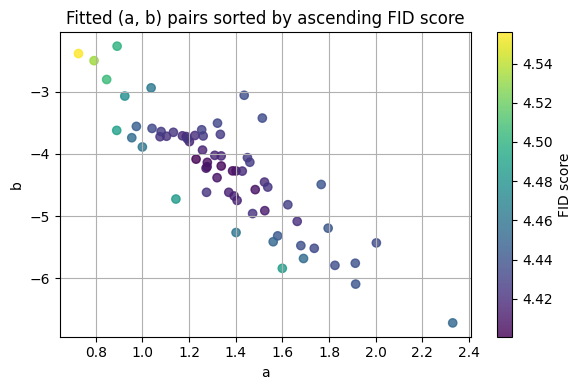

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
# df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")


# Filter for good trials
# df2 = df2[df2['fid_score'] < 4.53]

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue  # skip invalid

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']

    fits.append((fid, a, b))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b'])

# Filter for positive a
fits_df = fits_df[fits_df['a'] > 0]

# Sort by fid_score ascending
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Compute ranges
a_min, a_max = fits_df['a'].min(), fits_df['a'].max()
b_min, b_max = fits_df['b'].min(), fits_df['b'].max()

print("Estimated a range (positive):", (a_min, a_max))
print("Estimated b range (can be negative):", (b_min, b_max))

# Plot
plt.figure(figsize=(6,4))
sc = plt.scatter(fits_df['a'], fits_df['b'],
                 c=fits_df['fid_score'],
                 cmap='viridis', alpha=0.8)
plt.colorbar(sc, label='FID score')
plt.xlabel('a')
plt.ylabel('b')
plt.title('Fitted (a, b) pairs sorted by ascending FID score')
plt.grid(True)
plt.tight_layout()
plt.show()


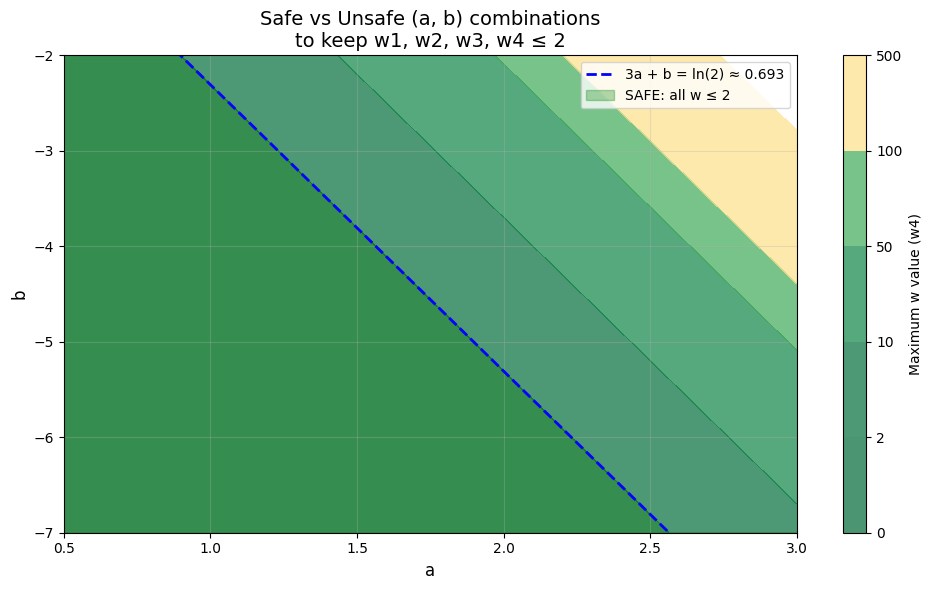

RULE TO AVOID LARGE VALUES:
To keep all w values ≤ 2:
AVOID: 3a + b > 0.693

Or equivalently:
SAFE when: b ≤ 0.693 - 3a

Examples:
--------------------------------------------------
a = 0.5 → b must be ≤ -0.81
a = 1.0 → b must be ≤ -2.31
a = 1.5 → b must be ≤ -3.81
a = 2.0 → b must be ≤ -5.31
a = 2.5 → b must be ≤ -6.81
a = 3.0 → b must be ≤ -8.31


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a_range = (0.5, 3)
b_range = (-7, -2)

# Create a grid of a and b values
a_vals = np.linspace(a_range[0], a_range[1], 100)
b_vals = np.linspace(b_range[0], b_range[1], 100)
A, B = np.meshgrid(a_vals, b_vals)

# Calculate max w value (w4) for each combination
i_max = 3
W_max = np.exp(i_max * A + B)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot contours
contour = plt.contourf(A, B, W_max, levels=[0, 2, 10, 50, 100, 500], 
                        cmap='RdYlGn_r', alpha=0.7)
plt.colorbar(contour, label='Maximum w value (w4)')

# Add the constraint line: 3a + b = ln(2)
constraint_b = np.log(2) - 3 * a_vals
plt.plot(a_vals, constraint_b, 'b--', linewidth=2, label='3a + b = ln(2) ≈ 0.693')

# Shade the safe region
plt.fill_between(a_vals, constraint_b, b_range[0], alpha=0.3, color='green', 
                 label='SAFE: all w ≤ 2')

plt.xlabel('a', fontsize=12)
plt.ylabel('b', fontsize=12)
plt.title('Safe vs Unsafe (a, b) combinations\nto keep w1, w2, w3, w4 ≤ 2', fontsize=14)
plt.xlim(a_range)
plt.ylim(b_range)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("RULE TO AVOID LARGE VALUES:")
print("=" * 50)
print("To keep all w values ≤ 2:")
print("AVOID: 3a + b > 0.693")
print("\nOr equivalently:")
print("SAFE when: b ≤ 0.693 - 3a")
print("\nExamples:")
print("-" * 50)
for a in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    b_max = np.log(2) - 3 * a
    print(f"a = {a:.1f} → b must be ≤ {b_max:.2f}")

Estimated a range (positive): (np.float64(0.5336400618771782), np.float64(2.731462900922447))
Estimated b range (can be negative): (np.float64(-6.972348221687252), np.float64(-2.1343519866009464))


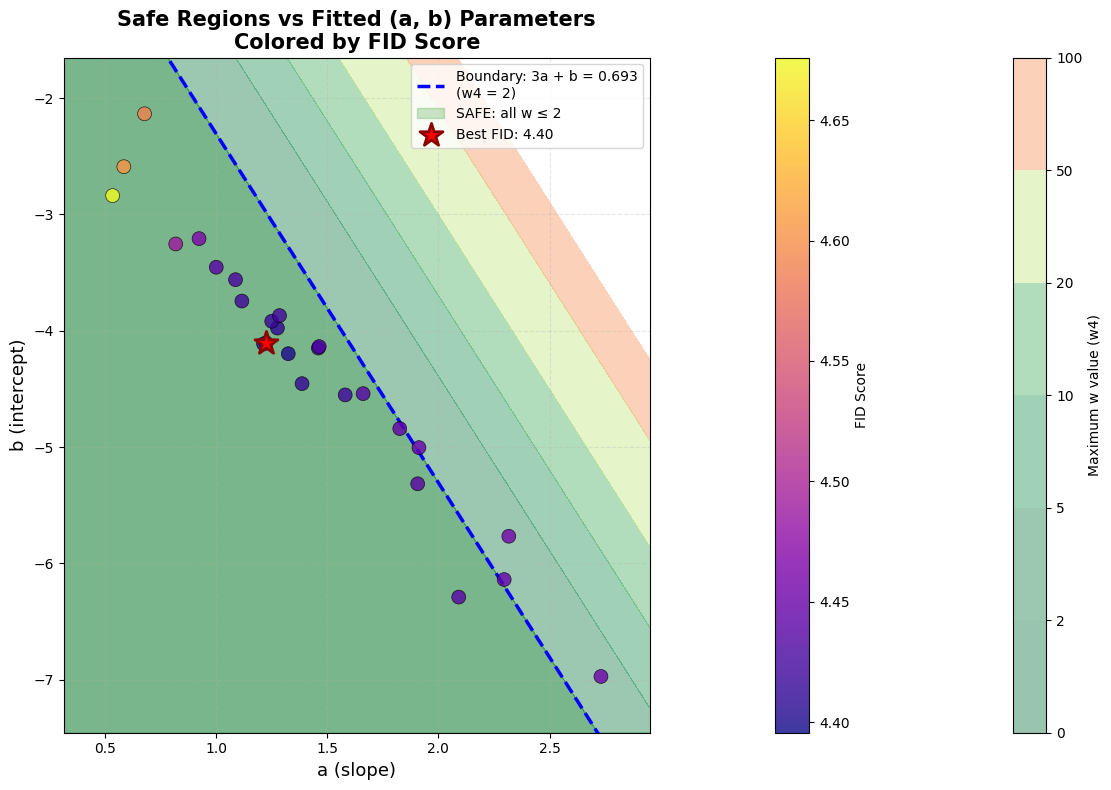


ANALYSIS:

Total points: 26
Safe points (w4 ≤ 2): 22 (84.6%)
Unsafe points (w4 > 2): 4 (15.4%)

Best FID score: 4.396
  a = 1.225, b = -4.104

Best SAFE FID score: 4.396
  a = 1.225, b = -4.104


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
# df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/fid_optimization_results.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue  # skip invalid

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']

    fits.append((fid, a, b))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b'])

# Filter for positive a
fits_df = fits_df[fits_df['a'] > 0]

# Sort by fid_score ascending
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Compute ranges for the plot
a_min, a_max = fits_df['a'].min(), fits_df['a'].max()
b_min, b_max = fits_df['b'].min(), fits_df['b'].max()

# Add some padding to the ranges
a_padding = (a_max - a_min) * 0.1
b_padding = (b_max - b_min) * 0.1
a_range = (max(0, a_min - a_padding), a_max + a_padding)
b_range = (b_min - b_padding, b_max + b_padding)

print("Estimated a range (positive):", (a_min, a_max))
print("Estimated b range (can be negative):", (b_min, b_max))

# Create a grid of a and b values for the background
a_vals = np.linspace(a_range[0], a_range[1], 200)
b_vals = np.linspace(b_range[0], b_range[1], 200)
A, B = np.meshgrid(a_vals, b_vals)

# Calculate max w value (w4) for each combination
i_max = 3
W_max = np.exp(i_max * A + B)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot contours for the safe/unsafe regions
contour = ax.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 50, 100], 
                       cmap='RdYlGn_r', alpha=0.4)
cbar1 = plt.colorbar(contour, ax=ax, label='Maximum w value (w4)', pad=0.1)

# Add the constraint line: 3a + b = ln(2)
constraint_b = np.log(2) - 3 * a_vals
ax.plot(a_vals, constraint_b, 'b--', linewidth=2.5, 
        label='Boundary: 3a + b = 0.693\n(w4 = 2)', zorder=5)

# Shade the safe region
ax.fill_between(a_vals, constraint_b, b_range[0], alpha=0.2, color='green', 
                label='SAFE: all w ≤ 2', zorder=1)

# Plot the fitted (a, b) points colored by FID score
sc = ax.scatter(fits_df['a'], fits_df['b'],
                c=fits_df['fid_score'],
                cmap='plasma', 
                s=100, 
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
                zorder=10)
cbar2 = plt.colorbar(sc, ax=ax, label='FID Score', pad=0.15)

# Mark the best FID point
best_idx = fits_df['fid_score'].idxmin()
best_row = fits_df.loc[best_idx]
ax.scatter(best_row['a'], best_row['b'], 
          s=300, marker='*', color='red', 
          edgecolors='darkred', linewidths=2,
          label=f'Best FID: {best_row["fid_score"]:.2f}',
          zorder=15)

ax.set_xlabel('a (slope)', fontsize=13)
ax.set_ylabel('b (intercept)', fontsize=13)
ax.set_title('Safe Regions vs Fitted (a, b) Parameters\nColored by FID Score', 
             fontsize=15, fontweight='bold')
ax.set_xlim(a_range)
ax.set_ylim(b_range)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*60)
print("ANALYSIS:")
print("="*60)
safe_threshold = np.log(2) - 3 * fits_df['a']
fits_df['is_safe'] = fits_df['b'] <= safe_threshold
n_safe = fits_df['is_safe'].sum()
n_total = len(fits_df)

print(f"\nTotal points: {n_total}")
print(f"Safe points (w4 ≤ 2): {n_safe} ({100*n_safe/n_total:.1f}%)")
print(f"Unsafe points (w4 > 2): {n_total - n_safe} ({100*(n_total-n_safe)/n_total:.1f}%)")

print(f"\nBest FID score: {fits_df['fid_score'].min():.3f}")
print(f"  a = {best_row['a']:.3f}, b = {best_row['b']:.3f}")
# print(f"  Is safe? {best_row['is_safe']}")

if n_safe > 0:
    safe_df = fits_df[fits_df['is_safe']]
    best_safe_idx = safe_df['fid_score'].idxmin()
    best_safe = safe_df.loc[best_safe_idx]
    print(f"\nBest SAFE FID score: {best_safe['fid_score']:.3f}")
    print(f"  a = {best_safe['a']:.3f}, b = {best_safe['b']:.3f}")

ANALYSIS OF BEST PERFORMING REGIONS

📊 TOP 10% PERFORMERS:
FID range: 4.372 - 4.380
a range:   1.018 - 1.176
b range:   -3.224 - -2.972
w4 range:  0.86 - 1.51

📊 TOP 25% PERFORMERS:
FID range: 4.372 - 4.386
a range:   0.856 - 2.453
b range:   -5.891 - -2.758
w4 range:  0.61 - 4.34

🎯 OPTUNA RANGE RECOMMENDATIONS

🔍 STRATEGY 1: Exploit Best Region (Conservative)
   Focus on refining around proven good performers
   a_range = (0.971, 1.223)
   b_range = (-3.299, -2.896)
   Expected w4: ~2.2 max

⚖️  STRATEGY 2: Balanced Exploration
   Cover good performers + unexplored promising areas
   a_range = (0.3, 1.5)
   b_range = (-4.5, -0.5)
   Expected w4: ~54.6 max

🛡️  STRATEGY 3: Constrained (w4 ≤ 5)
   Keep weights more controlled
   a_range = (0.2, 1.2)
   b_range = (-0.991, 1.009)
   Guaranteed w4 ≤ 5

🚀 STRATEGY 4: Aggressive - Dense Good Region
   Intensively search the densest cluster of good performers
   a_range = (0.6, 1.1)
   b_range = (-3.0, -1.3)
   Expected w4: ~7.4 max

⚠️  REG

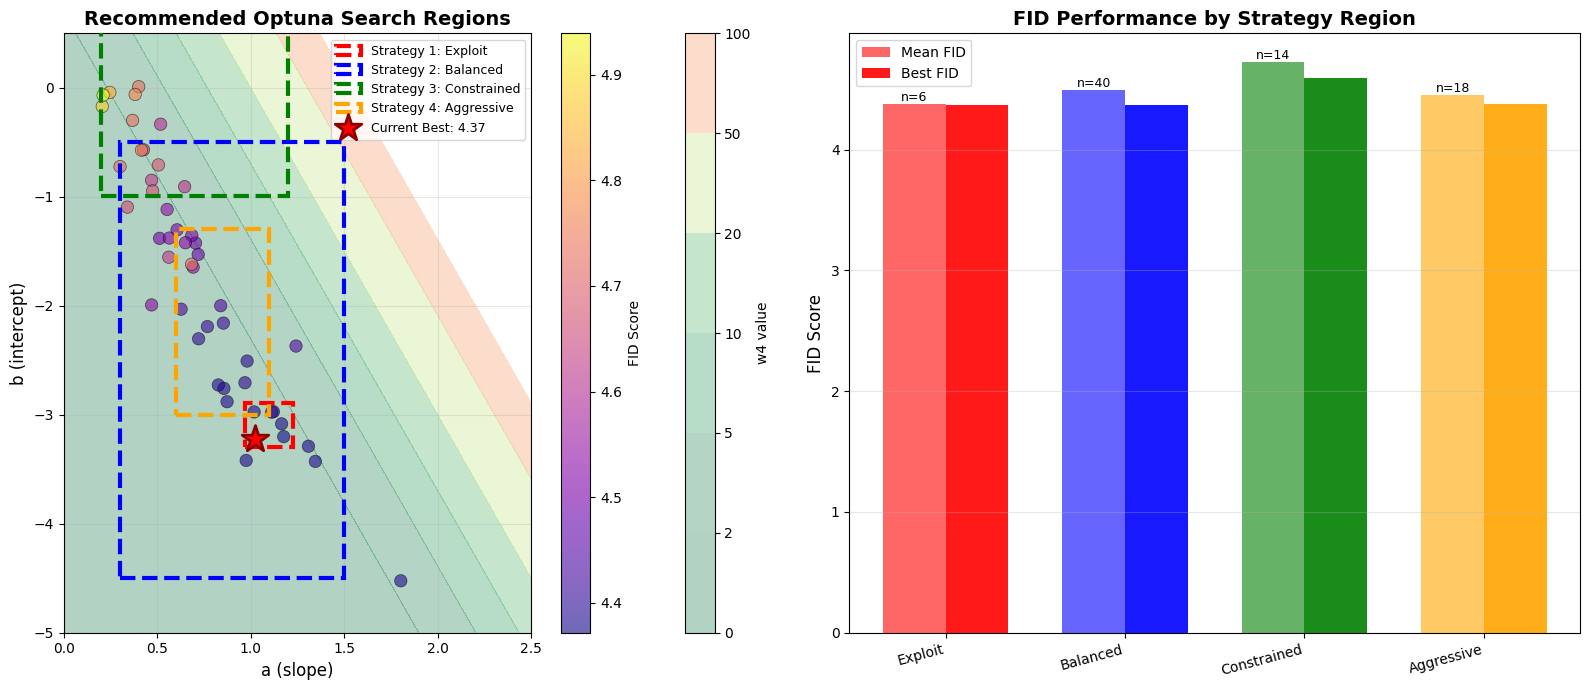


💡 RECOMMENDATION

Based on your data:

1. START with Strategy 4 (Aggressive) for 100-200 trials
   - This targets the densest cluster of good performers
   - High chance of finding improvements

2. If you need better FID at any cost:
   - Use Strategy 2 (Balanced) - allows larger w4 values
   
3. If you need controlled weights (w4 < 5):
   - Use Strategy 3 (Constrained)
   
4. For fine-tuning after finding a good region:
   - Use Strategy 1 (Exploit) with narrow ranges

Example Optuna code:
```python
def objective(trial):
    a = trial.suggest_float('a', 0.6, 1.1)  # Strategy 4
    b = trial.suggest_float('b', -3.0, -1.3)
    # ... rest of your code
```



In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    # Calculate actual w4 value
    w4 = np.exp(3*a + b)
    fits.append((fid, a, b, w4))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Analyze best performing regions
top_10_percent = fits_df.head(int(len(fits_df) * 0.1))
top_25_percent = fits_df.head(int(len(fits_df) * 0.25))

print("="*70)
print("ANALYSIS OF BEST PERFORMING REGIONS")
print("="*70)

print("\n📊 TOP 10% PERFORMERS:")
print(f"FID range: {top_10_percent['fid_score'].min():.3f} - {top_10_percent['fid_score'].max():.3f}")
print(f"a range:   {top_10_percent['a'].min():.3f} - {top_10_percent['a'].max():.3f}")
print(f"b range:   {top_10_percent['b'].min():.3f} - {top_10_percent['b'].max():.3f}")
print(f"w4 range:  {top_10_percent['w4'].min():.2f} - {top_10_percent['w4'].max():.2f}")

print("\n📊 TOP 25% PERFORMERS:")
print(f"FID range: {top_25_percent['fid_score'].min():.3f} - {top_25_percent['fid_score'].max():.3f}")
print(f"a range:   {top_25_percent['a'].min():.3f} - {top_25_percent['a'].max():.3f}")
print(f"b range:   {top_25_percent['b'].min():.3f} - {top_25_percent['b'].max():.3f}")
print(f"w4 range:  {top_25_percent['w4'].min():.2f} - {top_25_percent['w4'].max():.2f}")

print("\n" + "="*70)
print("🎯 OPTUNA RANGE RECOMMENDATIONS")
print("="*70)

# Strategy 1: Explore around best performers
a_best_min = top_10_percent['a'].min()
a_best_max = top_10_percent['a'].max()
b_best_min = top_10_percent['b'].min()
b_best_max = top_10_percent['b'].max()

a_margin = (a_best_max - a_best_min) * 0.3
b_margin = (b_best_max - b_best_min) * 0.3

strategy1_a = (max(0.01, a_best_min - a_margin), a_best_max + a_margin)
strategy1_b = (b_best_min - b_margin, b_best_max + b_margin)

print("\n🔍 STRATEGY 1: Exploit Best Region (Conservative)")
print("   Focus on refining around proven good performers")
print(f"   a_range = ({strategy1_a[0]:.3f}, {strategy1_a[1]:.3f})")
print(f"   b_range = ({strategy1_b[0]:.3f}, {strategy1_b[1]:.3f})")
print(f"   Expected w4: ~{np.exp(3*strategy1_a[1] + strategy1_b[1]):.1f} max")

# Strategy 2: Balanced exploration
strategy2_a = (0.3, 1.5)
strategy2_b = (-4.5, -0.5)

print("\n⚖️  STRATEGY 2: Balanced Exploration")
print("   Cover good performers + unexplored promising areas")
print(f"   a_range = {strategy2_a}")
print(f"   b_range = {strategy2_b}")
print(f"   Expected w4: ~{np.exp(3*strategy2_a[1] + strategy2_b[1]):.1f} max")

# Strategy 3: Constrained by w4 limit
max_w4_desired = 5  # You can adjust this
strategy3_a = (0.2, 1.2)
strategy3_b_max = np.log(max_w4_desired) - 3 * strategy3_a[0]
strategy3_b = (strategy3_b_max - 2, strategy3_b_max)

print("\n🛡️  STRATEGY 3: Constrained (w4 ≤ 5)")
print("   Keep weights more controlled")
print(f"   a_range = {strategy3_a}")
print(f"   b_range = ({strategy3_b[0]:.3f}, {strategy3_b[1]:.3f})")
print(f"   Guaranteed w4 ≤ {max_w4_desired}")

# Strategy 4: Aggressive exploration in promising dense region
strategy4_a = (0.6, 1.1)
strategy4_b = (-3.0, -1.3)

print("\n🚀 STRATEGY 4: Aggressive - Dense Good Region")
print("   Intensively search the densest cluster of good performers")
print(f"   a_range = {strategy4_a}")
print(f"   b_range = {strategy4_b}")
print(f"   Expected w4: ~{np.exp(3*strategy4_a[1] + strategy4_b[1]):.1f} max")

print("\n" + "="*70)
print("⚠️  REGIONS TO AVOID")
print("="*70)
print("\n❌ AVOID: a > 1.5 AND b > -2")
print("   → This produces extremely large w4 values (>100)")
print("\n❌ AVOID: a < 0.2")
print("   → Weights become too flat/uniform, less expressive")
print("\n❌ AVOID: b > 0")
print("   → All weights become large")
print("\n❌ AVOID: 3a + b > 3.0")
print("   → w4 > 20, likely too extreme")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Recommended regions
ax1 = axes[0]
a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 50, 100], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Plot all points
sc1 = ax1.scatter(fits_df['a'], fits_df['b'],
                  c=fits_df['fid_score'],
                  cmap='plasma', s=80, alpha=0.6,
                  edgecolors='black', linewidths=0.5, zorder=10)
plt.colorbar(sc1, ax=ax1, label='FID Score')

# Draw strategy rectangles
strategies = [
    (strategy1_a, strategy1_b, 'red', 'Strategy 1: Exploit'),
    (strategy2_a, strategy2_b, 'blue', 'Strategy 2: Balanced'),
    (strategy3_a, strategy3_b, 'green', 'Strategy 3: Constrained'),
    (strategy4_a, strategy4_b, 'orange', 'Strategy 4: Aggressive')
]

for a_rng, b_rng, color, label in strategies:
    rect = Rectangle((a_rng[0], b_rng[0]), 
                     a_rng[1]-a_rng[0], b_rng[1]-b_rng[0],
                     linewidth=3, edgecolor=color, facecolor='none',
                     linestyle='--', label=label, zorder=15)
    ax1.add_patch(rect)

# Mark best point
best_idx = fits_df['fid_score'].idxmin()
best_row = fits_df.loc[best_idx]
ax1.scatter(best_row['a'], best_row['b'], s=400, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Current Best: {best_row["fid_score"]:.2f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=12)
ax1.set_ylabel('b (intercept)', fontsize=12)
ax1.set_title('Recommended Optuna Search Regions', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Right plot: FID distribution by strategy
ax2 = axes[1]

def points_in_rect(df, a_rng, b_rng):
    return df[(df['a'] >= a_rng[0]) & (df['a'] <= a_rng[1]) & 
              (df['b'] >= b_rng[0]) & (df['b'] <= b_rng[1])]

strategy_data = []
for a_rng, b_rng, color, label in strategies:
    points = points_in_rect(fits_df, a_rng, b_rng)
    if len(points) > 0:
        strategy_data.append({
            'name': label.split(':')[1].strip(),
            'mean_fid': points['fid_score'].mean(),
            'min_fid': points['fid_score'].min(),
            'count': len(points),
            'color': color
        })

if strategy_data:
    names = [s['name'] for s in strategy_data]
    means = [s['mean_fid'] for s in strategy_data]
    mins = [s['min_fid'] for s in strategy_data]
    counts = [s['count'] for s in strategy_data]
    colors = [s['color'] for s in strategy_data]
    
    x = np.arange(len(names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, means, width, label='Mean FID', color=colors, alpha=0.6)
    bars2 = ax2.bar(x + width/2, mins, width, label='Best FID', color=colors, alpha=0.9)
    
    ax2.set_ylabel('FID Score', fontsize=12)
    ax2.set_title('FID Performance by Strategy Region', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=15, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars1, counts)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💡 RECOMMENDATION")
print("="*70)
print("""
Based on your data:

1. START with Strategy 4 (Aggressive) for 100-200 trials
   - This targets the densest cluster of good performers
   - High chance of finding improvements

2. If you need better FID at any cost:
   - Use Strategy 2 (Balanced) - allows larger w4 values
   
3. If you need controlled weights (w4 < 5):
   - Use Strategy 3 (Constrained)
   
4. For fine-tuning after finding a good region:
   - Use Strategy 1 (Exploit) with narrow ranges

Example Optuna code:
```python
def objective(trial):
    a = trial.suggest_float('a', 0.6, 1.1)  # Strategy 4
    b = trial.suggest_float('b', -3.0, -1.3)
    # ... rest of your code
```
""")

CONSTRAINT ANALYSIS: 3a + b < 4

What does 3a + b < 4 mean?
→ Since w4 = exp(3a + b), this means:
→ w4 < exp(4) = 54.60

✅ This keeps w4 under ~54.6

📊 YOUR DATA ANALYSIS:
Total points: 50
Points satisfying 3a + b < 4: 50 (100.0%)
Points violating 3a + b ≥ 4: 0 (0.0%)

🏆 BEST FID OVERALL:
FID: 4.372
a=1.022, b=-3.224
3a+b = -0.156
w4 = 0.86
Satisfies 3a+b<4? True

🏆 BEST FID WITH 3a+b<4:
FID: 4.372
a=1.022, b=-3.224
3a+b = -0.156
w4 = 0.86

📉 FID penalty for constraint: +0.000

📈 TOP 10% PERFORMERS:
Total in top 10%: 5
Satisfy constraint: 5 (100.0%)

COMPARISON: Different Constraint Levels
Constraint           Max w4       Points     Best FID     Median FID  
--------------------------------------------------------------------------------
w4 ≤ 2               2.0          37         4.372        4.451       
w4 ≤ 5               5.0          50         4.372        4.495       
w4 ≤ 10              10.0         50         4.372        4.495       
w4 ≤ 20              20.0         50  

/tmp/ipykernel_2581957/3106361036.py:143: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(violating['a'], violating['b'], c=violating['fid_score'],
/tmp/ipykernel_2581957/3106361036.py:191: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(violating['constraint_value'], violating['w4'],


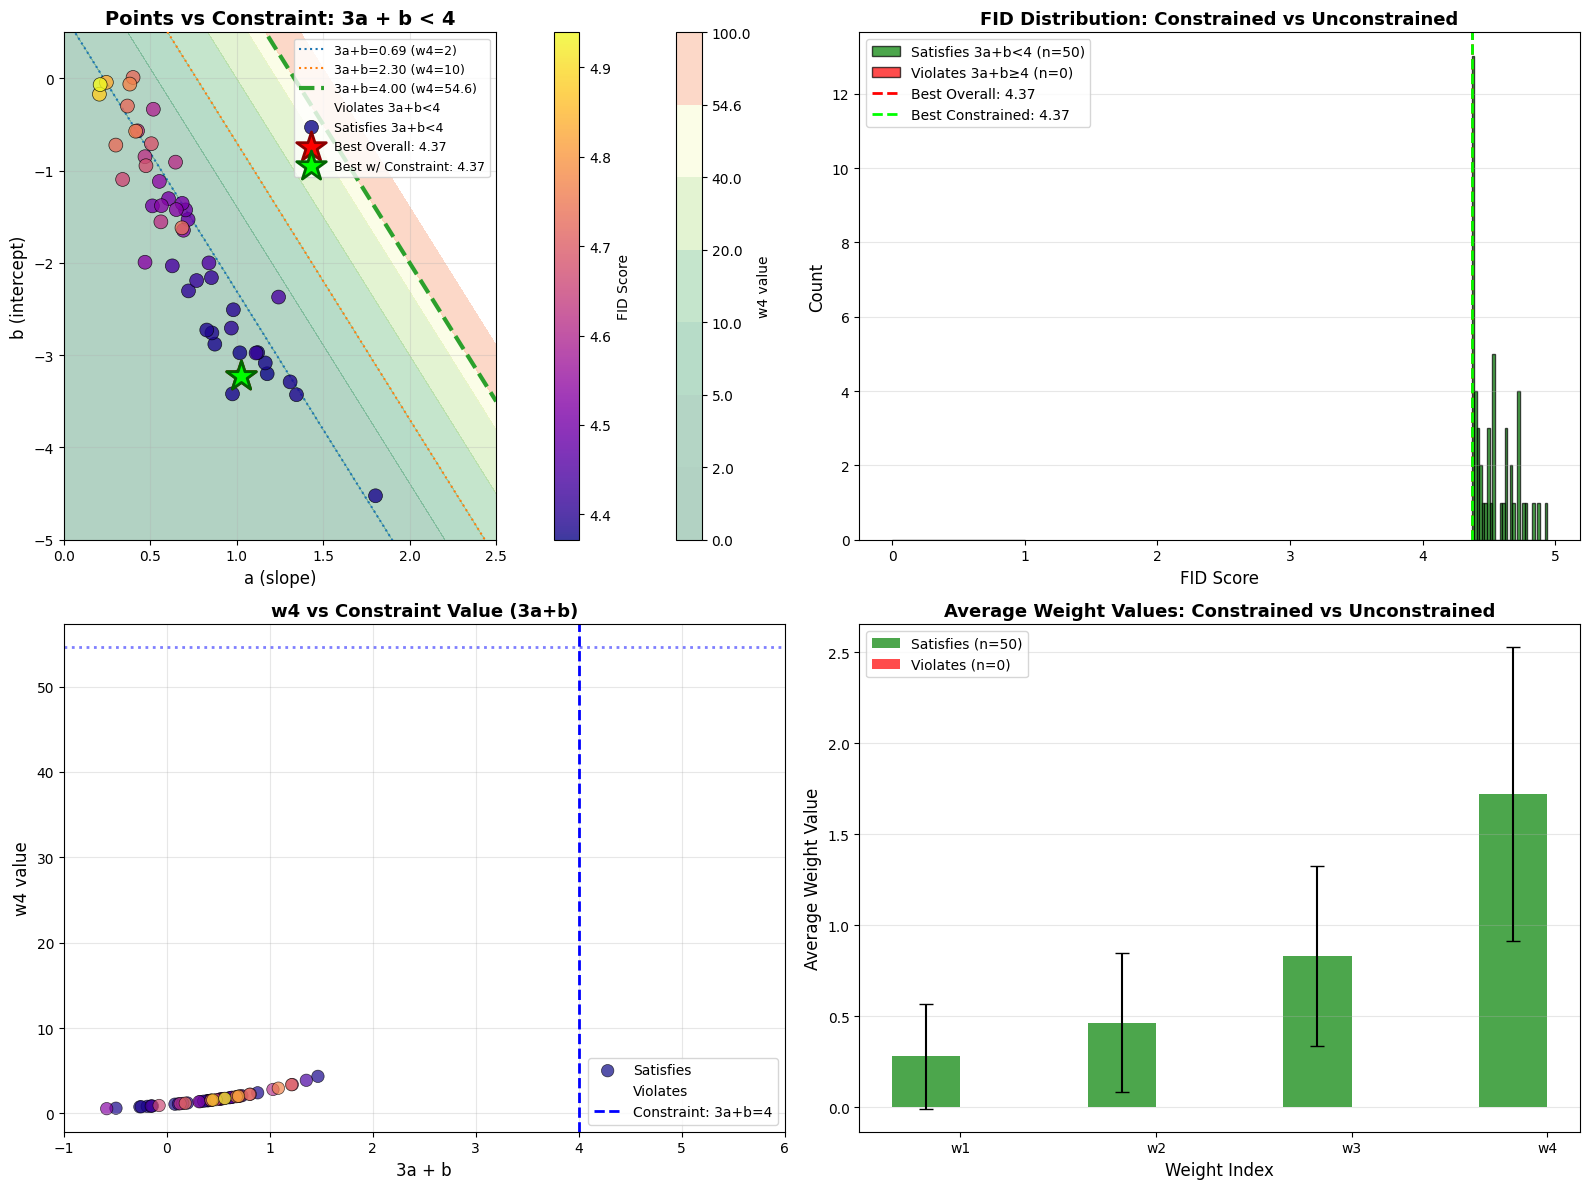


💡 CONCLUSION

Using 3a + b < 4 as a constraint:

✅ PROS:
  • Simple, single inequality to implement
  • Keeps w4 under ~54.6 (reasonable for most uses)
  • 100.0% of your existing data already satisfies it
  
⚠️  CONS:
  • May exclude some of your best performers
  • FID penalty: ~0.000 compared to unconstrained best
  
🎯 RECOMMENDATION:
  • If you're okay with w4 up to ~50: USE 3a + b < 4
  • If you need stricter control (w4 ≤ 20): USE 3a + b < 3.0
  • If you need very strict control (w4 ≤ 10): USE 3a + b < 2.3
  
📝 OPTUNA IMPLEMENTATION:
  ```python
  def objective(trial):
      a = trial.suggest_float('a', 0.3, 1.5)
      b = trial.suggest_float('b', -4.0, -0.5)
      
      # Add constraint
      if 3*a + b >= 4:
          return float('inf')  # Reject this trial
      
      # ... rest of your code
  ```



In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    # Calculate actual w values
    w1 = np.exp(b)
    w2 = np.exp(a + b)
    w3 = np.exp(2*a + b)
    w4 = np.exp(3*a + b)
    
    fits.append((fid, a, b, w1, w2, w3, w4))

# Convert to DataFrame
fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w1', 'w2', 'w3', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Apply constraint
fits_df['constraint_value'] = 3 * fits_df['a'] + fits_df['b']
fits_df['satisfies_constraint'] = fits_df['constraint_value'] < 4

# Different constraint levels
constraint_levels = [
    (0.693, 'w4 ≤ 2'),
    (1.609, 'w4 ≤ 5'),
    (2.303, 'w4 ≤ 10'),
    (2.996, 'w4 ≤ 20'),
    (3.689, 'w4 ≤ 40'),
    (4.0, 'w4 ≤ 54.6'),
    (4.605, 'w4 ≤ 100')
]

print("="*80)
print("CONSTRAINT ANALYSIS: 3a + b < 4")
print("="*80)

print(f"\nWhat does 3a + b < 4 mean?")
print(f"→ Since w4 = exp(3a + b), this means:")
print(f"→ w4 < exp(4) = {np.exp(4):.2f}")
print(f"\n✅ This keeps w4 under ~54.6")

# Analyze your data with this constraint
n_total = len(fits_df)
n_satisfying = fits_df['satisfies_constraint'].sum()
pct_satisfying = 100 * n_satisfying / n_total

print(f"\n📊 YOUR DATA ANALYSIS:")
print(f"Total points: {n_total}")
print(f"Points satisfying 3a + b < 4: {n_satisfying} ({pct_satisfying:.1f}%)")
print(f"Points violating 3a + b ≥ 4: {n_total - n_satisfying} ({100-pct_satisfying:.1f}%)")

# Best FID analysis
best_overall = fits_df.loc[fits_df['fid_score'].idxmin()]
satisfying_df = fits_df[fits_df['satisfies_constraint']]

print(f"\n🏆 BEST FID OVERALL:")
print(f"FID: {best_overall['fid_score']:.3f}")
print(f"a={best_overall['a']:.3f}, b={best_overall['b']:.3f}")
print(f"3a+b = {best_overall['constraint_value']:.3f}")
print(f"w4 = {best_overall['w4']:.2f}")
print(f"Satisfies 3a+b<4? {best_overall['satisfies_constraint']}")

if len(satisfying_df) > 0:
    best_constrained = satisfying_df.loc[satisfying_df['fid_score'].idxmin()]
    print(f"\n🏆 BEST FID WITH 3a+b<4:")
    print(f"FID: {best_constrained['fid_score']:.3f}")
    print(f"a={best_constrained['a']:.3f}, b={best_constrained['b']:.3f}")
    print(f"3a+b = {best_constrained['constraint_value']:.3f}")
    print(f"w4 = {best_constrained['w4']:.2f}")
    
    fid_loss = best_constrained['fid_score'] - best_overall['fid_score']
    print(f"\n📉 FID penalty for constraint: +{fid_loss:.3f}")

# Top performers analysis
top_10_pct = fits_df.head(int(0.1 * n_total))
top_10_satisfying = top_10_pct[top_10_pct['satisfies_constraint']]
print(f"\n📈 TOP 10% PERFORMERS:")
print(f"Total in top 10%: {len(top_10_pct)}")
print(f"Satisfy constraint: {len(top_10_satisfying)} ({100*len(top_10_satisfying)/len(top_10_pct):.1f}%)")

# Constraint level comparison
print(f"\n{'='*80}")
print("COMPARISON: Different Constraint Levels")
print(f"{'='*80}")
print(f"{'Constraint':<20} {'Max w4':<12} {'Points':<10} {'Best FID':<12} {'Median FID':<12}")
print(f"{'-'*80}")

for threshold, label in constraint_levels:
    subset = fits_df[fits_df['constraint_value'] < threshold]
    if len(subset) > 0:
        max_w4 = np.exp(threshold)
        n_points = len(subset)
        best_fid = subset['fid_score'].min()
        median_fid = subset['fid_score'].median()
        print(f"{label:<20} {max_w4:<12.1f} {n_points:<10} {best_fid:<12.3f} {median_fid:<12.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Main scatter with constraint line
ax1 = axes[0, 0]
a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 2, 5, 10, 20, 40, 54.6, 100], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Plot constraint lines
for threshold, label in [(0.693, 'w4=2'), (2.303, 'w4=10'), (4.0, 'w4=54.6')]:
    constraint_b = threshold - 3 * a_vals
    linestyle = '--' if threshold == 4.0 else ':'
    linewidth = 3 if threshold == 4.0 else 1.5
    ax1.plot(a_vals, constraint_b, linestyle, linewidth=linewidth, 
            label=f'3a+b={threshold:.2f} ({label})', zorder=5)

# Plot points
violating = fits_df[~fits_df['satisfies_constraint']]
satisfying = fits_df[fits_df['satisfies_constraint']]

ax1.scatter(violating['a'], violating['b'], c=violating['fid_score'],
           cmap='plasma', s=100, alpha=0.6, marker='x',
           edgecolors='red', linewidths=1.5, label='Violates 3a+b<4', zorder=10)
sc = ax1.scatter(satisfying['a'], satisfying['b'], c=satisfying['fid_score'],
                cmap='plasma', s=100, alpha=0.8, edgecolors='black', 
                linewidths=0.5, label='Satisfies 3a+b<4', zorder=11)
plt.colorbar(sc, ax=ax1, label='FID Score', pad=0.1)

ax1.scatter(best_overall['a'], best_overall['b'], s=500, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Best Overall: {best_overall["fid_score"]:.2f}', zorder=20)

if len(satisfying_df) > 0:
    ax1.scatter(best_constrained['a'], best_constrained['b'], s=500, marker='*', 
               color='lime', edgecolors='darkgreen', linewidths=2,
               label=f'Best w/ Constraint: {best_constrained["fid_score"]:.2f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=12)
ax1.set_ylabel('b (intercept)', fontsize=12)
ax1.set_title('Points vs Constraint: 3a + b < 4', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Plot 2: FID distribution
ax2 = axes[0, 1]
bins = 30
ax2.hist(satisfying_df['fid_score'], bins=bins, alpha=0.7, color='green', 
        label=f'Satisfies 3a+b<4 (n={len(satisfying_df)})', edgecolor='black')
ax2.hist(violating['fid_score'], bins=bins, alpha=0.7, color='red', 
        label=f'Violates 3a+b≥4 (n={len(violating)})', edgecolor='black')
ax2.axvline(best_overall['fid_score'], color='red', linestyle='--', linewidth=2,
           label=f'Best Overall: {best_overall["fid_score"]:.2f}')
if len(satisfying_df) > 0:
    ax2.axvline(best_constrained['fid_score'], color='lime', linestyle='--', linewidth=2,
               label=f'Best Constrained: {best_constrained["fid_score"]:.2f}')
ax2.set_xlabel('FID Score', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('FID Distribution: Constrained vs Unconstrained', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: w4 values
ax3 = axes[1, 0]
ax3.scatter(satisfying_df['constraint_value'], satisfying_df['w4'], 
           c=satisfying_df['fid_score'], cmap='plasma', s=80, alpha=0.7,
           edgecolors='black', linewidths=0.5, label='Satisfies')
ax3.scatter(violating['constraint_value'], violating['w4'], 
           c=violating['fid_score'], cmap='plasma', s=80, alpha=0.5,
           marker='x', edgecolors='red', linewidths=1.5, label='Violates')
ax3.axvline(4.0, color='blue', linestyle='--', linewidth=2, label='Constraint: 3a+b=4')
ax3.axhline(np.exp(4), color='blue', linestyle=':', linewidth=2, alpha=0.5)
ax3.set_xlabel('3a + b', fontsize=12)
ax3.set_ylabel('w4 value', fontsize=12)
ax3.set_title('w4 vs Constraint Value (3a+b)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, 6)

# Plot 4: Weight distributions
ax4 = axes[1, 1]
if len(satisfying_df) > 0:
    w_means_sat = [satisfying_df['w1'].mean(), satisfying_df['w2'].mean(), 
                   satisfying_df['w3'].mean(), satisfying_df['w4'].mean()]
    w_stds_sat = [satisfying_df['w1'].std(), satisfying_df['w2'].std(), 
                  satisfying_df['w3'].std(), satisfying_df['w4'].std()]
    
w_means_viol = [violating['w1'].mean(), violating['w2'].mean(), 
                violating['w3'].mean(), violating['w4'].mean()]
w_stds_viol = [violating['w1'].std(), violating['w2'].std(), 
               violating['w3'].std(), violating['w4'].std()]

x = np.arange(4)
width = 0.35

if len(satisfying_df) > 0:
    bars1 = ax4.bar(x - width/2, w_means_sat, width, yerr=w_stds_sat,
                   label=f'Satisfies (n={len(satisfying_df)})', 
                   color='green', alpha=0.7, capsize=5)
bars2 = ax4.bar(x + width/2, w_means_viol, width, yerr=w_stds_viol,
               label=f'Violates (n={len(violating)})', 
               color='red', alpha=0.7, capsize=5)

ax4.set_ylabel('Average Weight Value', fontsize=12)
ax4.set_xlabel('Weight Index', fontsize=12)
ax4.set_title('Average Weight Values: Constrained vs Unconstrained', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['w1', 'w2', 'w3', 'w4'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("💡 CONCLUSION")
print(f"{'='*80}")
print(f"""
Using 3a + b < 4 as a constraint:

✅ PROS:
  • Simple, single inequality to implement
  • Keeps w4 under ~54.6 (reasonable for most uses)
  • {pct_satisfying:.1f}% of your existing data already satisfies it
  
⚠️  CONS:
  • May exclude some of your best performers
  • FID penalty: ~{fid_loss:.3f} compared to unconstrained best
  
🎯 RECOMMENDATION:
  • If you're okay with w4 up to ~50: USE 3a + b < 4
  • If you need stricter control (w4 ≤ 20): USE 3a + b < 3.0
  • If you need very strict control (w4 ≤ 10): USE 3a + b < 2.3
  
📝 OPTUNA IMPLEMENTATION:
  ```python
  def objective(trial):
      a = trial.suggest_float('a', 0.3, 1.5)
      b = trial.suggest_float('b', -4.0, -0.5)
      
      # Add constraint
      if 3*a + b >= 4:
          return float('inf')  # Reject this trial
      
      # ... rest of your code
  ```
""")

CONSTRAINT ANALYSIS: ln(0.2) < 3a+b < ln(5)

Constraint bounds:
  Lower: 3a+b > ln(0.2) = -1.792
  Upper: 3a+b < ln(5)   = 1.792

What this means for w4:
  → 0.2 < w4 < 5
  → w4 must be between 0.2 and 5

📊 YOUR DATA ANALYSIS
Total points:                    50
✅ Satisfy ln(0.2)<3a+b<ln(5):    50 (100.0%)
❌ Too low (3a+b ≤ -1.79):      0 (  0.0%)
❌ Too high (3a+b ≥ 1.79):     0 (  0.0%)

🏆 BEST FID SCORES

Best Overall (No constraint):
  FID: 4.3716
  a=1.022, b=-3.224
  3a+b = -0.156
  w4 = 0.855
  ✅ Satisfies? True

Best with ln(0.2)<3a+b<ln(5):
  FID: 4.3716
  a=1.022, b=-3.224
  3a+b = -0.156
  w4 = 0.855

  📉 FID penalty: +0.0000

📈 TOP 10% PERFORMERS
Total in top 10%:          5
Satisfy constraint:        5 (100.0%)

FID range in constrained top 10%:
  Best:   4.3716
  Worst:  4.3799
  Median: 4.3765

📊 WEIGHT STATISTICS (Constrained points)
w1: mean=0.281, min=0.001, max=1.011
w2: mean=0.465, min=0.015, max=1.509
w3: mean=0.832, min=0.178, max=2.253
w4: mean=1.721, min=0.558, ma

/tmp/ipykernel_2581957/744400201.py:287: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


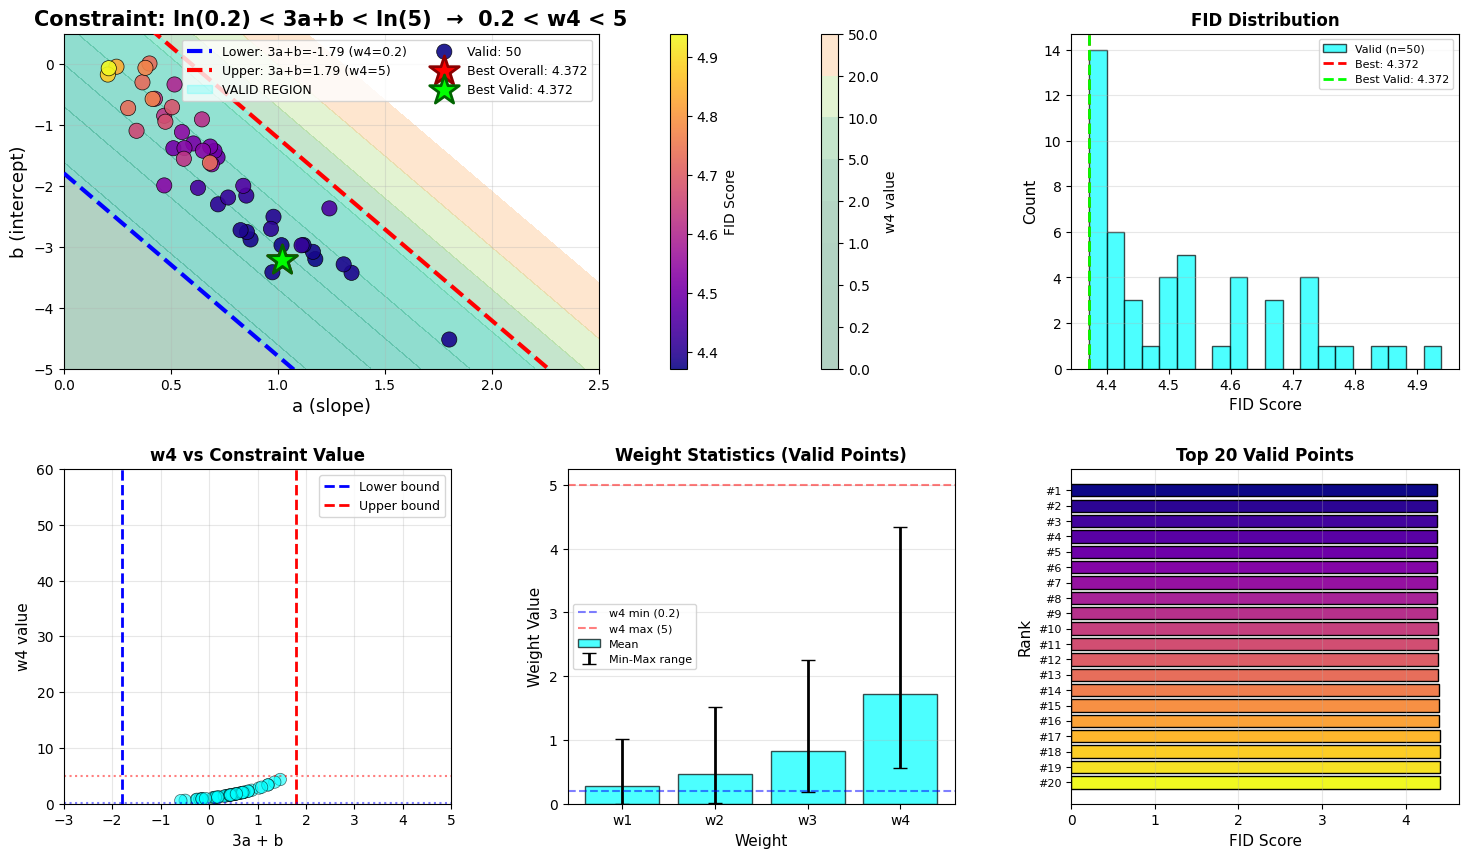


💡 VERDICT: ln(0.2) < 3a+b < ln(5)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load data
df2 = pd.read_csv("/home/cherish/SADD/sfd-main/evaluation_summary.csv")

fits = []

# Fit (a, b) for each trial
for _, row in df2.iterrows():
    w_vals = np.array([row['w1'], row['w2'], row['w3'], row['w4']])
    if np.any(w_vals <= 0):
        continue

    i = np.arange(4).reshape(-1, 1)
    log_w = np.log(w_vals)

    model = LinearRegression().fit(i, log_w)
    a = model.coef_[0]
    b = model.intercept_
    fid = row['fid_score']
    
    w1 = np.exp(b)
    w2 = np.exp(a + b)
    w3 = np.exp(2*a + b)
    w4 = np.exp(3*a + b)
    
    fits.append((fid, a, b, w1, w2, w3, w4))

fits_df = pd.DataFrame(fits, columns=['fid_score', 'a', 'b', 'w1', 'w2', 'w3', 'w4'])
fits_df = fits_df[fits_df['a'] > 0]
fits_df = fits_df.sort_values(by='fid_score').reset_index(drop=True)

# Calculate constraint bounds
lower_bound = np.log(1/6)  # ≈ -1.609
upper_bound = np.log(6)     # ≈ 1.609

fits_df['constraint_value'] = 3 * fits_df['a'] + fits_df['b']
fits_df['satisfies_constraint'] = (fits_df['constraint_value'] > lower_bound) & \
                                   (fits_df['constraint_value'] < upper_bound)

print("="*80)
print(f"CONSTRAINT ANALYSIS: ln(0.2) < 3a+b < ln(5)")
print("="*80)

print(f"\nConstraint bounds:")
print(f"  Lower: 3a+b > ln(0.2) = {lower_bound:.3f}")
print(f"  Upper: 3a+b < ln(5)   = {upper_bound:.3f}")
print(f"\nWhat this means for w4:")
print(f"  → 0.2 < w4 < 5")
print(f"  → w4 must be between 0.2 and 5")

# Analysis
n_total = len(fits_df)
n_satisfying = fits_df['satisfies_constraint'].sum()
n_too_low = (fits_df['constraint_value'] <= lower_bound).sum()
n_too_high = (fits_df['constraint_value'] >= upper_bound).sum()

print(f"\n{'='*80}")
print("📊 YOUR DATA ANALYSIS")
print(f"{'='*80}")
print(f"Total points:                    {n_total}")
print(f"✅ Satisfy ln(0.2)<3a+b<ln(5):   {n_satisfying:3d} ({100*n_satisfying/n_total:5.1f}%)")
print(f"❌ Too low (3a+b ≤ {lower_bound:.2f}):    {n_too_low:3d} ({100*n_too_low/n_total:5.1f}%)")
print(f"❌ Too high (3a+b ≥ {upper_bound:.2f}):   {n_too_high:3d} ({100*n_too_high/n_total:5.1f}%)")

# Best FID analysis
best_overall = fits_df.loc[fits_df['fid_score'].idxmin()]
satisfying_df = fits_df[fits_df['satisfies_constraint']]

print(f"\n{'='*80}")
print("🏆 BEST FID SCORES")
print(f"{'='*80}")

print(f"\nBest Overall (No constraint):")
print(f"  FID: {best_overall['fid_score']:.4f}")
print(f"  a={best_overall['a']:.3f}, b={best_overall['b']:.3f}")
print(f"  3a+b = {best_overall['constraint_value']:.3f}")
print(f"  w4 = {best_overall['w4']:.3f}")
print(f"  ✅ Satisfies? {best_overall['satisfies_constraint']}")

if len(satisfying_df) > 0:
    best_constrained = satisfying_df.loc[satisfying_df['fid_score'].idxmin()]
    print(f"\nBest with ln(0.2)<3a+b<ln(5):")
    print(f"  FID: {best_constrained['fid_score']:.4f}")
    print(f"  a={best_constrained['a']:.3f}, b={best_constrained['b']:.3f}")
    print(f"  3a+b = {best_constrained['constraint_value']:.3f}")
    print(f"  w4 = {best_constrained['w4']:.3f}")
    
    fid_penalty = best_constrained['fid_score'] - best_overall['fid_score']
    print(f"\n  📉 FID penalty: +{fid_penalty:.4f}")
else:
    print(f"\n⚠️  NO POINTS satisfy this constraint!")

# Top 10% analysis
top_10_pct = fits_df.head(int(0.1 * n_total))
top_10_satisfying = top_10_pct[top_10_pct['satisfies_constraint']]

print(f"\n{'='*80}")
print("📈 TOP 10% PERFORMERS")
print(f"{'='*80}")
print(f"Total in top 10%:          {len(top_10_pct)}")
print(f"Satisfy constraint:        {len(top_10_satisfying)} ({100*len(top_10_satisfying)/len(top_10_pct):.1f}%)")

if len(top_10_satisfying) > 0:
    print(f"\nFID range in constrained top 10%:")
    print(f"  Best:   {top_10_satisfying['fid_score'].min():.4f}")
    print(f"  Worst:  {top_10_satisfying['fid_score'].max():.4f}")
    print(f"  Median: {top_10_satisfying['fid_score'].median():.4f}")

# Weight statistics
if len(satisfying_df) > 0:
    print(f"\n{'='*80}")
    print("📊 WEIGHT STATISTICS (Constrained points)")
    print(f"{'='*80}")
    for i, w in enumerate(['w1', 'w2', 'w3', 'w4'], 1):
        mean_val = satisfying_df[w].mean()
        min_val = satisfying_df[w].min()
        max_val = satisfying_df[w].max()
        print(f"{w}: mean={mean_val:.3f}, min={min_val:.3f}, max={max_val:.3f}")

# Visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Main scatter
ax1 = fig.add_subplot(gs[0, :2])

a_vals = np.linspace(0, 2.5, 200)
b_vals = np.linspace(-5, 0.5, 200)
A, B = np.meshgrid(a_vals, b_vals)
W_max = np.exp(3 * A + B)

contour = ax1.contourf(A, B, W_max, levels=[0, 0.2, 0.5, 1, 2, 5, 10, 20, 50], 
                        cmap='RdYlGn_r', alpha=0.3)
plt.colorbar(contour, ax=ax1, label='w4 value')

# Draw constraint boundaries
lower_line = lower_bound - 3 * a_vals
upper_line = upper_bound - 3 * a_vals

ax1.plot(a_vals, lower_line, 'b--', linewidth=3, 
         label=f'Lower: 3a+b={lower_bound:.2f} (w4=0.2)', zorder=5)
ax1.plot(a_vals, upper_line, 'r--', linewidth=3, 
         label=f'Upper: 3a+b={upper_bound:.2f} (w4=5)', zorder=5)

# Shade the valid region
ax1.fill_between(a_vals, lower_line, upper_line, alpha=0.2, color='cyan', 
                 label='VALID REGION', zorder=1)

# Plot points
too_low = fits_df[fits_df['constraint_value'] <= lower_bound]
too_high = fits_df[fits_df['constraint_value'] >= upper_bound]
valid = fits_df[fits_df['satisfies_constraint']]

if len(too_low) > 0:
    ax1.scatter(too_low['a'], too_low['b'], c=too_low['fid_score'],
               cmap='plasma', s=80, alpha=0.4, marker='v',
               edgecolors='blue', linewidths=1.5, label=f'Too low (w4<0.2): {len(too_low)}', zorder=8)

if len(too_high) > 0:
    ax1.scatter(too_high['a'], too_high['b'], c=too_high['fid_score'],
               cmap='plasma', s=80, alpha=0.4, marker='^',
               edgecolors='red', linewidths=1.5, label=f'Too high (w4>5): {len(too_high)}', zorder=9)

if len(valid) > 0:
    sc = ax1.scatter(valid['a'], valid['b'], c=valid['fid_score'],
                    cmap='plasma', s=120, alpha=0.9, edgecolors='black', 
                    linewidths=0.5, label=f'Valid: {len(valid)}', zorder=10)
    plt.colorbar(sc, ax=ax1, label='FID Score', pad=0.1)

# Mark best points
ax1.scatter(best_overall['a'], best_overall['b'], s=500, marker='*', 
           color='red', edgecolors='darkred', linewidths=2,
           label=f'Best Overall: {best_overall["fid_score"]:.3f}', zorder=20)

if len(satisfying_df) > 0:
    ax1.scatter(best_constrained['a'], best_constrained['b'], s=500, marker='*', 
               color='lime', edgecolors='darkgreen', linewidths=2,
               label=f'Best Valid: {best_constrained["fid_score"]:.3f}', zorder=20)

ax1.set_xlabel('a (slope)', fontsize=13)
ax1.set_ylabel('b (intercept)', fontsize=13)
ax1.set_title('Constraint: ln(0.2) < 3a+b < ln(5)  →  0.2 < w4 < 5', 
             fontsize=15, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(-5, 0.5)

# Plot 2: FID distribution
ax2 = fig.add_subplot(gs[0, 2])

if len(valid) > 0:
    ax2.hist(valid['fid_score'], bins=20, alpha=0.7, color='cyan', 
            edgecolor='black', label=f'Valid (n={len(valid)})')
if len(too_low) > 0 or len(too_high) > 0:
    invalid = pd.concat([too_low, too_high])
    ax2.hist(invalid['fid_score'], bins=20, alpha=0.5, color='gray', 
            edgecolor='black', label=f'Invalid (n={len(invalid)})')

ax2.axvline(best_overall['fid_score'], color='red', linestyle='--', linewidth=2,
           label=f'Best: {best_overall["fid_score"]:.3f}')
if len(satisfying_df) > 0:
    ax2.axvline(best_constrained['fid_score'], color='lime', linestyle='--', linewidth=2,
               label=f'Best Valid: {best_constrained["fid_score"]:.3f}')

ax2.set_xlabel('FID Score', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('FID Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Constraint value vs w4
ax3 = fig.add_subplot(gs[1, 0])

ax3.scatter(fits_df['constraint_value'], fits_df['w4'], 
           c=fits_df['satisfies_constraint'].map({True: 'cyan', False: 'gray'}),
           s=80, alpha=0.6, edgecolors='black', linewidths=0.5)

ax3.axvline(lower_bound, color='blue', linestyle='--', linewidth=2, label='Lower bound')
ax3.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label='Upper bound')
ax3.axhline(0.2, color='blue', linestyle=':', linewidth=1.5, alpha=0.5)
ax3.axhline(5, color='red', linestyle=':', linewidth=1.5, alpha=0.5)

ax3.set_xlabel('3a + b', fontsize=11)
ax3.set_ylabel('w4 value', fontsize=11)
ax3.set_title('w4 vs Constraint Value', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-3, 5)
ax3.set_ylim(0, 60)

# Plot 4: Weight ranges
ax4 = fig.add_subplot(gs[1, 1])

if len(valid) > 0:
    weights = ['w1', 'w2', 'w3', 'w4']
    means = [valid[w].mean() for w in weights]
    mins = [valid[w].min() for w in weights]
    maxs = [valid[w].max() for w in weights]
    
    x = np.arange(len(weights))
    ax4.bar(x, means, alpha=0.7, color='cyan', edgecolor='black', label='Mean')
    ax4.errorbar(x, means, yerr=[np.array(means)-np.array(mins), 
                                   np.array(maxs)-np.array(means)],
                fmt='none', ecolor='black', capsize=5, linewidth=2, label='Min-Max range')
    
    ax4.axhline(0.2, color='blue', linestyle='--', linewidth=1.5, alpha=0.5, label='w4 min (0.2)')
    ax4.axhline(5, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='w4 max (5)')
    
    ax4.set_ylabel('Weight Value', fontsize=11)
    ax4.set_xlabel('Weight', fontsize=11)
    ax4.set_title('Weight Statistics (Valid Points)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(weights)
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'No valid points!', ha='center', va='center', 
            fontsize=16, color='red', transform=ax4.transAxes)

# Plot 5: Top performers
ax5 = fig.add_subplot(gs[1, 2])

if len(satisfying_df) > 0:
    top_n = min(20, len(satisfying_df))
    top_valid = satisfying_df.head(top_n)
    
    y_pos = np.arange(len(top_valid))
    colors = plt.cm.plasma(np.linspace(0, 1, len(top_valid)))
    
    ax5.barh(y_pos, top_valid['fid_score'].values, color=colors, edgecolor='black')
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels([f"#{i+1}" for i in range(len(top_valid))], fontsize=8)
    ax5.set_xlabel('FID Score', fontsize=11)
    ax5.set_ylabel('Rank', fontsize=11)
    ax5.set_title(f'Top {top_n} Valid Points', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')
else:
    ax5.text(0.5, 0.5, 'No valid points!', ha='center', va='center', 
            fontsize=16, color='red', transform=ax5.transAxes)

plt.tight_layout()
plt.show()

# Final recommendation
print(f"\n{'='*80}")
print("💡 VERDICT: ln(0.2) < 3a+b < ln(5)")
print(f"{'='*80}")

# if len(satisfying_df) == 0:
#     print("\n❌ CRITICAL: NO points in your data satisfy this constraint!")
#     print("\n⚠️  This constraint is TOO RESTRICTIVE for your problem.")
#     print("\nRECOMMENDATION: Use a looser constraint like:")
#     print("  • 3a+b < 3.0  (w4 < 20)")
#     print("  • 3a+b < 4.0  (w4 < 54.6)")
# elif n_satisfying < n_total * 0.1:
#     print(f"\n⚠️  Only {n_satisfying} points ({100*n_satisfying/n_total:.1f}%) satisf

In [ ]:
cifar_10_optuna_with_fid_as_target_nfe_3_afs_true = """
            trial_number,exp_folder,a,b,c,d,w1,w2,w3,w4,fid_score,state
            0,00000-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5214345738929326,0.9010331729673894,0.35733936081549655,0.23704187931081733,0.5214345738929326,1.422467746860322,1.7798071076758184,2.016848986986636,4.75948465733303,COMPLETE
            1,00001-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2752816445697047,0.36734060995759243,0.08982052129999274,0.6155907244788834,0.2752816445697047,0.6426222545272972,0.7324427758272899,1.3480335003061734,4.568842970339417,COMPLETE
            2,00002-cifar10-4-2-dpmpp-3-poly7.0-afs,0.6665321615944915,0.80051753291427,0.9227768130914088,0.7332228269645313,0.6665321615944915,1.4670496945087614,2.38982650760017,3.1230493345647012,4.724249847536093,COMPLETE
            3,00003-cifar10-4-2-dpmpp-3-poly7.0-afs,0.6468989971843006,0.5254456568913537,0.7847133899522196,0.31193187426931945,0.6468989971843006,1.1723446540756544,1.957058044027874,2.2689899182971933,4.732301032254901,COMPLETE
            4,00004-cifar10-4-2-dpmpp-3-poly7.0-afs,0.7694917025625719,0.9514929028861738,0.0955850481528292,0.8253002258066996,0.7694917025625719,1.7209846054487459,1.816569653601575,2.6418698794082744,4.779179089078816,COMPLETE
            5,00005-cifar10-4-2-dpmpp-3-poly7.0-afs,0.20428457469096073,0.03497032462156935,0.9197694681298696,0.04018643225060259,0.20428457469096073,0.23925489931253008,1.1590243674423997,1.1992107996930024,4.536722026075779,COMPLETE
            6,00006-cifar10-4-2-dpmpp-3-poly7.0-afs,0.904487754817614,0.5178845731395884,0.23783436046669026,0.5784281747347888,0.904487754817614,1.4223723279572025,1.6602066884238926,2.2386348631586817,4.799573210282303,COMPLETE
            7,00007-cifar10-4-2-dpmpp-3-poly7.0-afs,0.9598398008238161,0.38751402109152666,0.15558659933717822,0.19306835585769466,0.9598398008238161,1.347353821915343,1.502940421252521,1.6960087771102157,4.854008157934793,COMPLETE
            8,00008-cifar10-4-2-dpmpp-3-poly7.0-afs,0.41772646805492164,0.43546023985341986,0.3858320314985417,0.10106808943057188,0.41772646805492164,0.8531867079083415,1.2390187394068832,1.340086828837455,4.6811205060891155,COMPLETE
            9,00009-cifar10-4-2-dpmpp-3-poly7.0-afs,0.49046640831991006,0.13797187076007777,0.8895325061978254,0.7494671124778659,0.49046640831991006,0.6284382790799878,1.5179707852778133,2.2674378977556793,4.581914835836763,COMPLETE
            10,00010-cifar10-4-2-dpmpp-3-poly7.0-afs,0.006233300291375116,0.036161782905462375,0.6538672437135049,0.000899525989785932,0.006233300291375116,0.04239508319683749,0.6962623269103424,0.6971618529001283,4.446654219167107,COMPLETE
            11,00011-cifar10-4-2-dpmpp-3-poly7.0-afs,0.01477071037362817,0.009100963404357239,0.6591059918407404,0.3834525553822953,0.01477071037362817,0.023871673777985408,0.6829776656187257,1.066430221001021,4.438931843310913,COMPLETE
            12,00012-cifar10-4-2-dpmpp-3-poly7.0-afs,0.005178660904115982,0.1858929391738981,0.6267217810824077,0.4142891069172735,0.005178660904115982,0.19107160007801408,0.8177933811604218,1.2320824880776953,4.459749241812137,COMPLETE
            13,00013-cifar10-4-2-dpmpp-3-poly7.0-afs,0.019956695023658762,8.276384983714469e-05,0.631564584324081,0.9658945547778515,0.019956695023658762,0.020039458873495907,0.6516040431975769,1.6174985979754284,4.443925905277622,COMPLETE
            14,00014-cifar10-4-2-dpmpp-3-poly7.0-afs,0.1776369044467995,0.23829826880107785,0.564704210707055,0.9778965399372131,0.1776369044467995,0.4159351732478773,0.9806393839549323,1.9585359238921454,4.495822831617254,COMPLETE
            15,00015-cifar10-4-2-dpmpp-3-poly7.0-afs,0.11196409557722795,0.27359414459054393,0.723829025284031,0.4111136800360242,0.11196409557722795,0.38555824016777185,1.1093872654518029,1.520500945487827,4.5174088767453515,COMPLETE
            16,00016-cifar10-4-2-dpmpp-3-poly7.0-afs,0.33671906075833136,0.7044783330396581,0.4687150194297884,0.960406906859552,0.33671906075833136,1.0411973937979895,1.509912413227778,2.47031932008733,4.627890139611278,COMPLETE
            17,00017-cifar10-4-2-dpmpp-3-poly7.0-afs,0.11536202346196324,0.024605337017072553,0.8003330939328297,0.5839917706797357,0.11536202346196324,0.1399673604790358,0.9403004544118655,1.5242922250916013,4.454125450621798,COMPLETE
            18,00018-cifar10-4-2-dpmpp-3-poly7.0-afs,0.31489827781860813,0.6239467320945281,0.47684697311614416,0.4543925827047073,0.31489827781860813,0.9388450099131362,1.4156919830292805,1.8700845657339877,4.626829369443312,COMPLETE
            19,00019-cifar10-4-2-dpmpp-3-poly7.0-afs,0.04552913267770779,0.13623697440614865,0.5866093411198128,0.31869436778996674,0.04552913267770779,0.18176610708385643,0.7683754482036692,1.0870698159936358,4.4643798488676385,COMPLETE
            20,00020-cifar10-4-2-dpmpp-3-poly7.0-afs,0.21146144678355372,0.25780126777583406,0.7061840686554071,0.842447734107515,0.21146144678355372,0.4692627145593878,1.1754467832147948,2.0178945173223095,4.506229820740472,COMPLETE
            21,00021-cifar10-4-2-dpmpp-3-poly7.0-afs,0.020727581227924334,0.03287387354951145,0.6324361206548856,0.000890155569598372,0.020727581227924334,0.05360145477743578,0.6860375754323215,0.6869277310019198,4.435658114628152,COMPLETE
            22,00022-cifar10-4-2-dpmpp-3-poly7.0-afs,0.10303103694196217,0.08972420699978015,0.5297787597317452,0.17274001726613097,0.10303103694196217,0.19275524394174232,0.7225340036734875,0.8952740209396185,4.484459244649895,COMPLETE
            23,00023-cifar10-4-2-dpmpp-3-poly7.0-afs,0.07601590203795128,0.003905703445805861,0.8026350528547626,0.5034330644347208,0.07601590203795128,0.07992160548375714,0.8825566583385197,1.3859897227732405,4.453637052313398,COMPLETE
            24,00024-cifar10-4-2-dpmpp-3-poly7.0-afs,0.18046929449696836,0.11439534773407724,0.3868194845440168,0.3047570418993119,0.18046929449696836,0.2948646422310456,0.6816841267750624,0.9864411686743744,4.514422836333078,COMPLETE
            25,00025-cifar10-4-2-dpmpp-3-poly7.0-afs,0.26209500215019266,0.1685138006039562,0.6847008086967271,0.6981688213713606,0.26209500215019266,0.43060880275414887,1.115309611450876,1.8134784328222366,4.5182707364809485,COMPLETE
            26,00026-cifar10-4-2-dpmpp-3-poly7.0-afs,0.3906395092860854,0.3148058919036593,0.7535337094982025,0.11614387692616301,0.3906395092860854,0.7054454011897446,1.458979110687947,1.57512298761411,4.652799845619926,COMPLETE
            27,00027-cifar10-4-2-dpmpp-3-poly7.0-afs,0.00551535495040258,0.19878452303432836,0.8502140739347371,0.892589239032212,0.00551535495040258,0.20429987798473095,1.0545139519194682,1.94710319095168,4.458904606079038,COMPLETE
            28,00028-cifar10-4-2-dpmpp-3-poly7.0-afs,0.14111943770107424,0.062575339158213,0.9760762380822977,0.5141328111617413,0.14111943770107424,0.20369477685928725,1.179771014941585,1.6939038261033263,4.4730176225220175,COMPLETE
            29,00029-cifar10-4-2-dpmpp-3-poly7.0-afs,0.06804481574270677,0.00421597667572526,0.25492694226356605,0.24106715719549224,0.06804481574270677,0.07226079241843203,0.3271877346819981,0.5682548918774903,4.417308643445493,COMPLETE
            30,00030-cifar10-4-2-dpmpp-3-poly7.0-afs,0.49533356170986187,0.08843572320649705,0.28893936553870747,0.25489916702035276,0.49533356170986187,0.5837692849163589,0.8727086504550664,1.1276078174754192,4.643737159727742,COMPLETE
            31,00031-cifar10-4-2-dpmpp-3-poly7.0-afs,0.06457828233251095,0.009042670916206422,0.4453577733080207,0.4010673558242379,0.06457828233251095,0.07362095324871737,0.518978726556738,0.920046082380976,4.436067226970875,COMPLETE
            32,00032-cifar10-4-2-dpmpp-3-poly7.0-afs,0.07289426468953078,0.0925945303141478,0.2892005841976652,0.3478347657078243,0.07289426468953078,0.16548879500367858,0.4546893792013438,0.802524144909168,4.431610895418059,COMPLETE
            33,00033-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2474079704458357,0.0941357111937784,0.3165967181900175,0.2559708466154765,0.2474079704458357,0.3415436816396141,0.6581403998296316,0.914111246445108,4.5421992412647665,COMPLETE
            34,00034-cifar10-4-2-dpmpp-3-poly7.0-afs,0.14399942383440686,0.1898273199115642,0.17095298413249221,0.16663511486159344,0.14399942383440686,0.3338267437459711,0.5047797278784634,0.6714148427400568,4.527451754919386,COMPLETE
            35,00035-cifar10-4-2-dpmpp-3-poly7.0-afs,0.07607215529185832,0.8644629406153979,0.014805652884336218,0.3676866411331337,0.07607215529185832,0.9405350959072561,0.9553407487915924,1.323027389924726,4.614958437976162,COMPLETE
            36,00036-cifar10-4-2-dpmpp-3-poly7.0-afs,0.649404579288833,0.3313689899848157,0.43365004894611164,0.08531313331179362,0.649404579288833,0.9807735692736487,1.4144236182197603,1.4997367515315538,4.732087196523049,COMPLETE
            37,00037-cifar10-4-2-dpmpp-3-poly7.0-afs,0.7470708758240365,0.08218554959862329,0.23937965974179679,0.3201816821945802,0.7470708758240365,0.8292564254226598,1.0686360851644565,1.3888177673590367,4.716945425661419,COMPLETE
            38,00038-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5806318985981097,0.5850275183333284,0.3255408136078395,0.19979714741310783,0.5806318985981097,1.165659416931438,1.4912002305392775,1.6909973779523852,4.743657214929087,COMPLETE
            39,00039-cifar10-4-2-dpmpp-3-poly7.0-afs,0.06957933758356313,0.39898282809549035,0.24762350156297494,0.049835747460776285,0.06957933758356313,0.4685621656790535,0.7161856672420285,0.7660214147028047,4.545444553463143,COMPLETE
            40,00040-cifar10-4-2-dpmpp-3-poly7.0-afs,0.224904878743271,0.15089927174470144,0.1734160128955461,0.464639341173267,0.224904878743271,0.37580415048797244,0.5492201633835185,1.0138595045567855,4.517956041448155,COMPLETE
            41,00041-cifar10-4-2-dpmpp-3-poly7.0-afs,0.1555261657185813,0.0002608650313117647,0.5240722671695531,0.37598102398580574,0.1555261657185813,0.15578703074989306,0.6798592979194462,1.055840321905252,4.471976368042129,COMPLETE
            42,00042-cifar10-4-2-dpmpp-3-poly7.0-afs,0.06574903589064379,0.05442750534895975,0.4191327207518025,0.3681645314978441,0.06574903589064379,0.12017654123960354,0.539309261991406,0.9074737934892502,4.438596093218784,COMPLETE
            43,00043-cifar10-4-2-dpmpp-3-poly7.0-afs,0.07484955646715102,0.057763528673513025,0.42249007366341756,0.23757429517301856,0.07484955646715102,0.13261308514066406,0.5551031588040816,0.7926774539771001,4.443797388449372,COMPLETE
            44,00044-cifar10-4-2-dpmpp-3-poly7.0-afs,0.28421237383787046,0.22600593716325063,0.37366529359488715,0.29873429414996083,0.28421237383787046,0.5102183110011211,0.8838836045960083,1.1826178987459692,4.571195578371311,COMPLETE
            45,00045-cifar10-4-2-dpmpp-3-poly7.0-afs,0.052308907468283886,0.12640819151533322,0.41909945639405866,0.5462307482955842,0.052308907468283886,0.1787170989836171,0.5978165553776758,1.14404730367326,4.446351641918038,COMPLETE
            46,00046-cifar10-4-2-dpmpp-3-poly7.0-afs,0.11763443472542551,0.05097273552002339,0.11949171158717939,0.6663209123083638,0.11763443472542551,0.1686071702454489,0.28809888183262833,0.9544197941409921,4.42941795917557,COMPLETE
            47,00047-cifar10-4-2-dpmpp-3-poly7.0-afs,0.182372256282042,0.049918285024482714,0.20572773406958528,0.6237494164359167,0.182372256282042,0.2322905413065247,0.43801827537611,1.0617676918120267,4.462937917389552,COMPLETE
            48,00048-cifar10-4-2-dpmpp-3-poly7.0-afs,0.13244193028189732,0.4619228164412199,0.08943400148554845,0.7087600124692017,0.13244193028189732,0.5943647467231172,0.6837987482086657,1.3925587606778675,4.531699968973203,COMPLETE
            49,00049-cifar10-4-2-dpmpp-3-poly7.0-afs,0.8413738750636972,0.12403268076437196,0.09948927835262195,0.6104218000414525,0.8413738750636972,0.9654065558280691,1.0648958341806911,1.6753176342221436,4.728219496523776,COMPLETE

"""

cifar_10_optuna_with_min_loss_of_last_step_nfe_3_afs_false_mean_loss_of_step_2 = """
exp_folder,w1,w2,w3,w4,loss
00000-cifar10-4-3-dpmpp-3-poly7.0,0.11086389586005191,0.30162514761469544,0.6034981739725551,1.0,4.3652029
00001-cifar10-4-3-dpmpp-3-poly7.0,0.313550869287932,0.4857789136039329,0.5447368927618589,1.0,4.36577845
00002-cifar10-4-3-dpmpp-3-poly7.0,0.2313646208264602,0.4911475396130181,0.7385044937935618,1.0,4.38017654
00003-cifar10-4-3-dpmpp-3-poly7.0,0.08941820532946632,0.16137267368617064,0.5233850768960125,1.0,4.35179758
00004-cifar10-4-3-dpmpp-3-poly7.0,0.08441011729148365,0.2774465727158445,0.34774554488970866,1.0,4.35896206
00005-cifar10-4-3-dpmpp-3-poly7.0,0.057785250091734124,0.3275610307774933,0.6107945979297493,1.0,4.37341309
00006-cifar10-4-3-dpmpp-3-poly7.0,0.19354562252577037,0.3669408631006517,0.448963843020774,1.0,4.35766125
00007-cifar10-4-3-dpmpp-3-poly7.0,0.16396765861843438,0.16726216665144944,0.4479213747010749,1.0,4.3411603
00008-cifar10-4-3-dpmpp-3-poly7.0,0.2922042098946123,0.30432131687615155,0.57263328768998,1.0,4.34610701
00009-cifar10-4-3-dpmpp-3-poly7.0,0.29901070342221975,0.3308656653485919,0.5322367008378645,1.0,4.34638929
00010-cifar10-4-3-dpmpp-3-poly7.0,0.2565126004862643,0.5217644441328878,0.5811288615778158,1.0,4.3751092
00011-cifar10-4-3-dpmpp-3-poly7.0,0.21138522919986305,0.22634532519794218,0.3922406360697744,1.0,4.34131384
00012-cifar10-4-3-dpmpp-3-poly7.0,0.23112097822288336,0.24264686929789453,0.4571261320484385,1.0,4.34200096
00013-cifar10-4-3-dpmpp-3-poly7.0,0.2135401470344347,0.38745497487573766,0.6731303613330655,1.0,4.36801767
00014-cifar10-4-3-dpmpp-3-poly7.0,0.05745311936038788,0.06016310824332108,0.2683623426733326,1.0,4.34175301
00015-cifar10-4-3-dpmpp-3-poly7.0,0.16861064293662048,0.17634941213875113,0.3835760215563159,1.0,4.34294367
00016-cifar10-4-3-dpmpp-3-poly7.0,0.13484534340973758,0.4116468095776329,0.7037893623368301,1.0,4.37568378
00017-cifar10-4-3-dpmpp-3-poly7.0,0.22425738452484628,0.48950730745088744,0.7095141939676346,1.0,4.3782177
00018-cifar10-4-3-dpmpp-3-poly7.0,0.29219262500085036,0.29925915221060156,0.338998035774447,1.0,4.33465719
00019-cifar10-4-3-dpmpp-3-poly7.0,0.18534681229293765,0.21148491108565046,0.23721308796096974,1.0,4.3365736
00020-cifar10-4-3-dpmpp-3-poly7.0,0.2372959271603192,0.26556407750572836,0.2825825225243505,1.0,4.33996105
00021-cifar10-4-3-dpmpp-3-poly7.0,0.3953708113242303,0.3963793312559551,0.40079071476102324,1.0,4.34227037
00022-cifar10-4-3-dpmpp-3-poly7.0,0.06364743071629121,0.06556275441897631,0.10456176208805817,1.0,4.33789873
00023-cifar10-4-3-dpmpp-3-poly7.0,0.15246654542961363,0.15363580555479067,0.5722217435774005,1.0,4.34251595
00024-cifar10-4-3-dpmpp-3-poly7.0,0.18124431841410968,0.2417276329444983,0.5441021327212798,1.0,4.35167885
00025-cifar10-4-3-dpmpp-3-poly7.0,0.1454257334062149,0.2948589463760734,0.531950306454916,1.0,4.35581017
00026-cifar10-4-3-dpmpp-3-poly7.0,0.21000166407762005,0.2963677511436088,0.6118091713990803,1.0,4.35454893
00027-cifar10-4-3-dpmpp-3-poly7.0,0.3149962064771238,0.31650175370864553,0.648557029053362,1.0,4.35023785
00028-cifar10-4-3-dpmpp-3-poly7.0,0.005742308010231067,0.22017205330226355,0.590338108360543,1.0,4.36749077
00029-cifar10-4-3-dpmpp-3-poly7.0,0.09482982209612882,0.23859368852810564,0.46241659475385366,1.0,4.35383415
00030-cifar10-4-3-dpmpp-3-poly7.0,0.2549366208549564,0.533490250217665,0.6276824087146918,1.0,4.37758398
00031-cifar10-4-3-dpmpp-3-poly7.0,0.3288170067774167,0.3453974696486638,0.4639418712132892,1.0,4.34277248
00032-cifar10-4-3-dpmpp-3-poly7.0,0.009892581295252442,0.0180339046639147,0.4551728560356774,1.0,4.34423208
00033-cifar10-4-3-dpmpp-3-poly7.0,0.24743321304042662,0.25034696982120447,0.36847414620305935,1.0,4.33907032
00034-cifar10-4-3-dpmpp-3-poly7.0,0.1049914544512274,0.11306755166647911,0.20703842634742575,1.0,4.33489227
00035-cifar10-4-3-dpmpp-3-poly7.0,0.02083656008875315,0.025521526928882675,0.5122129646927569,1.0,4.34232283
00036-cifar10-4-3-dpmpp-3-poly7.0,0.3923139855322907,0.3953597263322155,0.5930168047687702,1.0,4.35254478
00037-cifar10-4-3-dpmpp-3-poly7.0,0.3129459930561821,0.33748720892710754,0.3877573883637668,1.0,4.33939028
00038-cifar10-4-3-dpmpp-3-poly7.0,0.036811177535855735,0.12374273671042416,0.46575750705351643,1.0,4.34849167
00039-cifar10-4-3-dpmpp-3-poly7.0,0.12249315618657147,0.15296224395132854,0.1600713278786533,1.0,4.33514881
00040-cifar10-4-3-dpmpp-3-poly7.0,0.13640997121821227,0.1609524316722137,0.2129338374812005,1.0,4.33601999
00041-cifar10-4-3-dpmpp-3-poly7.0,0.022133387161263594,0.493816241850998,0.5177431121834246,1.0,4.39138603
00042-cifar10-4-3-dpmpp-3-poly7.0,0.2427581301547432,0.26252712469386025,0.6269530017096762,1.0,4.34666252
00043-cifar10-4-3-dpmpp-3-poly7.0,0.4664318263581107,0.4807306256374852,0.5077666143554086,1.0,4.35625029
00044-cifar10-4-3-dpmpp-3-poly7.0,0.1835615305811771,0.18963963030891892,0.2125310789128616,1.0,4.33660889
00045-cifar10-4-3-dpmpp-3-poly7.0,0.005798456159005471,0.006725429074420994,0.14294796956657532,1.0,4.34151077
00046-cifar10-4-3-dpmpp-3-poly7.0,0.25827642992032096,0.45586969829921653,0.6788072428884372,1.0,4.37182426
00047-cifar10-4-3-dpmpp-3-poly7.0,0.12518894703778408,0.19159092281766715,0.2043096451542544,1.0,4.34104395
00048-cifar10-4-3-dpmpp-3-poly7.0,0.009010769350128716,0.010948180186489333,0.35889769567828705,1.0,4.34456635
00049-cifar10-4-3-dpmpp-3-poly7.0,0.21504716503652524,0.42302751503927694,0.6367318567797362,1.0,4.36628342
00050-cifar10-4-3-dpmpp-3-poly7.0,0.06624961516451756,0.2270274311036056,0.5504013420582398,1.0,4.35851765
00051-cifar10-4-3-dpmpp-3-poly7.0,0.14375247632635493,0.14416443720989067,0.2898032442179295,1.0,4.33630943
00052-cifar10-4-3-dpmpp-3-poly7.0,0.2042100702228074,0.20604997826352098,0.5572813042662552,1.0,4.34304428
00053-cifar10-4-3-dpmpp-3-poly7.0,0.2895070604776987,0.38629656898307396,0.691537167189185,1.0,4.35961246"""



cifar_10_optuna_with_min_loss_of_last_step_nfe_3_afs_false_min_loss_of_step_2 = """
exp_folder,w1,w2,w3,w4,loss
00057-cifar10-4-3-dpmpp-3-poly7.0,0.0600530828313048,0.1948198161524506,0.5794605296493404,1.0,4.28730249
00058-cifar10-4-3-dpmpp-3-poly7.0,0.17063302317895007,0.24608915084996355,0.5110555631616406,1.0,4.30762863
00059-cifar10-4-3-dpmpp-3-poly7.0,0.08527495431689362,0.4269860445704862,0.4395413754563635,1.0,4.32399273
00060-cifar10-4-3-dpmpp-3-poly7.0,0.015398474434761165,0.27446171237292716,0.5667892521672789,1.0,4.29564571
00061-cifar10-4-3-dpmpp-3-poly7.0,0.19980495657657135,0.4410699987446244,0.709611924297597,1.0,4.36504126
00062-cifar10-4-3-dpmpp-3-poly7.0,0.014167788156340236,0.04634241583869268,0.5062559992664549,1.0,4.24299717
00063-cifar10-4-3-dpmpp-3-poly7.0,0.21342674285311472,0.3493283544256305,0.6405989794513831,1.0,4.34384823
00064-cifar10-4-3-dpmpp-3-poly7.0,0.1971291753553611,0.4588760244718337,0.7047226073889239,1.0,4.36747885
00065-cifar10-4-3-dpmpp-3-poly7.0,0.21053275327746485,0.4669788533972703,0.681924139779667,1.0,4.37027121
00066-cifar10-4-3-dpmpp-3-poly7.0,0.11535685351503674,0.43694798443175326,0.492384428977909,1.0,4.33493805
00067-cifar10-4-3-dpmpp-3-poly7.0,0.08678823950405529,0.4406039567407336,0.5726032701966852,1.0,4.33882999
00068-cifar10-4-3-dpmpp-3-poly7.0,0.03702329239103384,0.3369314127280573,0.47515578417542614,1.0,4.30129004
00069-cifar10-4-3-dpmpp-3-poly7.0,0.006146011249593918,0.03926559720172233,0.43076621677422056,1.0,4.23565006
00070-cifar10-4-3-dpmpp-3-poly7.0,0.0067937937792934494,0.006974938421125069,0.29546476431015783,1.0,4.2272892
00071-cifar10-4-3-dpmpp-3-poly7.0,0.43620739442896256,0.4390483692691444,0.5633308100227921,1.0,4.39568567
00072-cifar10-4-3-dpmpp-3-poly7.0,0.004790721866653417,0.015284577279766912,0.40887584656443415,1.0,4.2302103
00073-cifar10-4-3-dpmpp-3-poly7.0,0.01809408485400782,0.02756838168374568,0.37816101206920183,1.0,4.23224926
00074-cifar10-4-3-dpmpp-3-poly7.0,0.15046227655556732,0.4081740289372562,0.5214467292059645,1.0,4.33737707
00075-cifar10-4-3-dpmpp-3-poly7.0,0.0019913299592599757,0.007943236051587888,0.44456887167677334,1.0,4.22939205
00076-cifar10-4-3-dpmpp-3-poly7.0,0.19865072086037733,0.5117293553619107,0.6047840351655724,1.0,4.37136364
00077-cifar10-4-3-dpmpp-3-poly7.0,0.12835901921059753,0.2494157216636483,0.5635580806492392,1.0,4.3054781
00078-cifar10-4-3-dpmpp-3-poly7.0,0.009232004501990854,0.020955280904667327,0.2608017008648955,1.0,4.22892094
00079-cifar10-4-3-dpmpp-3-poly7.0,0.017015365364320037,0.04221215051173074,0.22411081444393707,1.0,4.23148727
00080-cifar10-4-3-dpmpp-3-poly7.0,0.009579063766934664,0.38242049179098514,0.4632638712583769,1.0,4.30606365
00081-cifar10-4-3-dpmpp-3-poly7.0,0.03263551026573138,0.0413533318581514,0.26320086584758423,1.0,4.23390388
00082-cifar10-4-3-dpmpp-3-poly7.0,0.013849938088272565,0.060104947381131965,0.06985419318608192,1.0,4.24455452
00083-cifar10-4-3-dpmpp-3-poly7.0,0.3309170288742224,0.3590411120790795,0.5587336284032685,1.0,4.35944176
00084-cifar10-4-3-dpmpp-3-poly7.0,0.34398410006100383,0.4756514257853926,0.5126752403240459,1.0,4.38485241
00085-cifar10-4-3-dpmpp-3-poly7.0,0.01753625344869512,0.051063225782232935,0.31580259620605305,1.0,4.23293066
00086-cifar10-4-3-dpmpp-3-poly7.0,0.030607038665553046,0.034374887947249924,0.30707807902374457,1.0,4.23424435
00087-cifar10-4-3-dpmpp-3-poly7.0,0.0014437472951855162,0.03104370159687008,0.31473270966092487,1.0,4.23073578
00088-cifar10-4-3-dpmpp-3-poly7.0,0.05045553857572864,0.0583911346709377,0.5008243749443182,1.0,4.24996662
00089-cifar10-4-3-dpmpp-3-poly7.0,0.20799434507724918,0.3090732655630613,0.5163802701402646,1.0,4.3247962
00090-cifar10-4-3-dpmpp-3-poly7.0,0.01060773830654347,0.1530701318896082,0.2955482744462409,1.0,4.24709415
00091-cifar10-4-3-dpmpp-3-poly7.0,0.31152094494137067,0.38562759906224436,0.6543501256530685,1.0,4.36755848
00092-cifar10-4-3-dpmpp-3-poly7.0,0.01004140747391803,0.025661822891309673,0.236307774279533,1.0,4.23036194
00093-cifar10-4-3-dpmpp-3-poly7.0,0.004079333568512052,0.023900816163829282,0.37832218491423036,1.0,4.23057222
00094-cifar10-4-3-dpmpp-3-poly7.0,0.028427832549689516,0.12038565029660533,0.2865767492246149,1.0,4.24377155
00095-cifar10-4-3-dpmpp-3-poly7.0,0.017004351110817835,0.017223341706348386,0.1909024994805004,1.0,4.23455334
00096-cifar10-4-3-dpmpp-3-poly7.0,0.0251313861752945,0.34190664037657514,0.6645740876724332,1.0,4.31752539
00097-cifar10-4-3-dpmpp-3-poly7.0,0.010539150229016251,0.012345229014762083,0.3604154367487793,1.0,4.23054504
00098-cifar10-4-3-dpmpp-3-poly7.0,0.0884918247645422,0.37385910297070407,0.5579488214746803,1.0,4.32356453
00099-cifar10-4-3-dpmpp-3-poly7.0,0.042708132712864735,0.22573555431701833,0.25012063638710574,1.0,4.25989246
00100-cifar10-4-3-dpmpp-3-poly7.0,0.011020185451889888,0.014394209471995307,0.4812270470956948,1.0,4.23453999
00101-cifar10-4-3-dpmpp-3-poly7.0,0.012817724158673655,0.04264781030236663,0.1887212669198596,1.0,4.23543835
00102-cifar10-4-3-dpmpp-3-poly7.0,0.0016350371176592816,0.036552464281652076,0.21776986188902203,1.0,4.23081875
00103-cifar10-4-3-dpmpp-3-poly7.0,0.0007617949577813028,0.04284288392901961,0.27154788472071534,1.0,4.22767067
00104-cifar10-4-3-dpmpp-3-poly7.0,0.03105748108633626,0.03323888280381541,0.4473929716439897,1.0,4.2385602
00105-cifar10-4-3-dpmpp-3-poly7.0,0.009915884493077818,0.03966017866228738,0.47003991086573166,1.0,4.23721981
00106-cifar10-4-3-dpmpp-3-poly7.0,0.1434164993114933,0.44551602466680496,0.6742595231443721,1.0,4.35498667
00107-cifar10-4-3-dpmpp-3-poly7.0,0.40589922777874315,0.4510445374922041,0.5635391594318117,1.0,4.39221478
00108-cifar10-4-3-dpmpp-3-poly7.0,0.09633534351230547,0.1059332137557405,0.13185286652003012,1.0,4.25110197
00109-cifar10-4-3-dpmpp-3-poly7.0,0.018858535542329767,0.020020224733242352,0.4096326437299458,1.0,4.23258114
00110-cifar10-4-3-dpmpp-3-poly7.0,0.004234171552924707,0.06369718126723622,0.32796871235375447,1.0,4.23458767
"""


cifar_10_optuna_with_min_loss_of_last_step_nfe_3_afs_false_min_loss_of_step_2_branch_3_optuna = """
trial_number,exp_folder,a,b,c,d,w1,w2,w3,w4,loss,state
0,00000-cifar10-4-2-dpmpp-3-poly7.0-afs,0.408062739782438,0.10970284377971296,0.2498075472723914,0.35737938168535777,0.408062739782438,0.517765583562151,0.7675731308345424,1.1249525125199002,4.84078407,COMPLETE
1,00001-cifar10-4-2-dpmpp-3-poly7.0-afs,0.8476753271316241,0.11055255709549927,0.3218515755390403,0.9595284044434237,0.8476753271316241,0.9582278842271233,1.2800794597661636,2.2396078642095874,4.83840847,COMPLETE
2,00002-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5062789878867746,0.2160312899665161,0.6670219001853048,0.6058465036371082,0.5062789878867746,0.7223102778532907,1.3893321780385954,1.9951786816757036,4.80946445,COMPLETE
3,00003-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5111607673672165,0.9455785351062042,0.5431942281402221,0.7497967385322853,0.5111607673672165,1.4567393024734208,1.9999335306136428,2.749730269145928,4.82982826,COMPLETE
4,00004-cifar10-4-2-dpmpp-3-poly7.0-afs,0.6725430285003856,0.26930990055294457,0.04611731823215992,0.6572160965325887,0.6725430285003856,0.9418529290533302,0.9879702472854901,1.6451863438180787,4.86125469,COMPLETE
5,00005-cifar10-4-2-dpmpp-3-poly7.0-afs,0.7740868562423422,0.9154523184954402,0.9953072354016538,0.47922625287615717,0.7740868562423422,1.6895391747377824,2.684846410139436,3.164072663015593,4.83980846,COMPLETE
6,00006-cifar10-4-2-dpmpp-3-poly7.0-afs,0.9417135127881682,0.31554929940637,0.3011708152135322,0.6901545773767966,0.9417135127881682,1.2572628121945382,1.5584336274080703,2.248588204784867,4.86037016,COMPLETE
7,00007-cifar10-4-2-dpmpp-3-poly7.0-afs,0.03336913998944713,0.585444838833471,0.25825185863429523,0.4921364281412063,0.03336913998944713,0.6188139788229181,0.8770658374572133,1.3692022655984197,4.794806,COMPLETE
8,00008-cifar10-4-2-dpmpp-3-poly7.0-afs,0.14304772387548725,0.8037413984505227,0.5870050170824287,0.10492515684523496,0.14304772387548725,0.94678912232601,1.5337941394084387,1.6387192962536736,4.82860565,COMPLETE
9,00009-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5860278297518242,0.18828867289337348,0.030221185928574035,0.4960764270799116,0.5860278297518242,0.7743165026451977,0.8045376885737717,1.3006141156536835,4.87150002,COMPLETE
10,00010-cifar10-4-2-dpmpp-3-poly7.0-afs,0.034338027694276504,0.5816414444703495,0.7836580223556691,0.22352616240190148,0.034338027694276504,0.615979472164626,1.3996374945202952,1.6231636569221966,4.79287338,COMPLETE
11,00011-cifar10-4-2-dpmpp-3-poly7.0-afs,0.01585498206799823,0.6132106317009662,0.8133145768666897,0.17527181907962774,0.01585498206799823,0.6290656137689644,1.4423801906356541,1.617652009715282,4.79508781,COMPLETE
12,00012-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2674726782361996,0.5448119482415237,0.8044803156536949,0.2969023796541899,0.2674726782361996,0.8122846264777233,1.616764942131418,1.913667321785608,4.81096935,COMPLETE
13,00013-cifar10-4-2-dpmpp-3-poly7.0-afs,0.01982606407929451,0.7343805403431951,0.4029971112361371,0.00036523109525243846,0.01982606407929451,0.7542066044224897,1.1572037156586268,1.1575689467538792,4.83285618,COMPLETE
14,00014-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2683322242067566,0.43972843407044887,0.13168758847385742,0.3259048613035107,0.2683322242067566,0.7080606582772055,0.839748246751063,1.1656531080545736,4.8483181,COMPLETE
15,00015-cifar10-4-2-dpmpp-3-poly7.0-afs,0.1662688030303564,0.6684621182459154,0.9880806081590092,0.8816601956213621,0.1662688030303564,0.8347309212762718,1.8228115294352811,2.704471725056643,4.78201771,COMPLETE
16,00016-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2057915705231606,0.4127810700987766,0.9956797090367517,0.9967000850866147,0.2057915705231606,0.6185726406219372,1.614252349658689,2.6109524347453035,4.77318144,COMPLETE
17,00017-cifar10-4-2-dpmpp-3-poly7.0-afs,0.2647797027339334,0.41062438602795404,0.9745203840133414,0.9462559549258739,0.2647797027339334,0.6754040887618875,1.649924472775229,2.596180427701103,4.77940941,COMPLETE
18,00018-cifar10-4-2-dpmpp-3-poly7.0-afs,0.3743125481398015,0.40692230877820545,0.8802637928106292,0.9937880781449169,0.3743125481398015,0.781234856918007,1.6614986497286361,2.655286727873553,4.78706264,COMPLETE
19,00019-cifar10-4-2-dpmpp-3-poly7.0-afs,0.32012858966221386,0.3763772532713068,0.6936157760296214,0.8344551799179039,0.32012858966221386,0.6965058429335207,1.3901216189631422,2.224576798881046,4.78887177,COMPLETE
20,00020-cifar10-4-2-dpmpp-3-poly7.0-afs,0.14857767605467298,0.008478757435162021,0.8966345276035627,0.85885287080651,0.14857767605467298,0.157056433489835,1.0536909610933978,1.9125438318999077,4.74949217,COMPLETE
21,00021-cifar10-4-2-dpmpp-3-poly7.0-afs,0.1730666502829747,0.023582014742224836,0.9150419463792747,0.8640804644580536,0.1730666502829747,0.1966486650251995,1.1116906114044742,1.9757710758625278,4.75376511,COMPLETE
22,00022-cifar10-4-2-dpmpp-3-poly7.0-afs,0.15064510507511927,0.006959111978105428,0.8746266177026308,0.8145913997434121,0.15064510507511927,0.1576042170532247,1.0322308347558555,1.8468222344992675,4.75083447,COMPLETE
23,00023-cifar10-4-2-dpmpp-3-poly7.0-afs,0.13117115656330247,0.028911881699839936,0.8715620810531721,0.8013841392994009,0.13117115656330247,0.1600830382631424,1.0316451193163145,1.8330292586157153,4.74894619,COMPLETE
24,00024-cifar10-4-2-dpmpp-3-poly7.0-afs,0.09562157574585821,0.006584027874753651,0.7085029719677343,0.7742981622515295,0.09562157574585821,0.10220560362061186,0.8107085755883461,1.5850067378398756,4.74241257,COMPLETE
25,00025-cifar10-4-2-dpmpp-3-poly7.0-afs,0.10277034370940363,0.09000509619684278,0.7134080371528126,0.7407242061384545,0.10277034370940363,0.1927754399062464,0.9061834770590591,1.6469076831975136,4.75088215,COMPLETE
26,00026-cifar10-4-2-dpmpp-3-poly7.0-afs,0.09387945664331498,0.16808647857092085,0.6288149139410638,0.5965216415882271,0.09387945664331498,0.26196593521423583,0.8907808491552996,1.4873024907435268,4.76243353,COMPLETE
27,00027-cifar10-4-2-dpmpp-3-poly7.0-afs,0.3907485834182975,0.0046553341892940575,0.4834929883671104,0.7691317276161825,0.3907485834182975,0.3954039176075915,0.8788969059747019,1.6480286335908845,4.78536749,COMPLETE
28,00028-cifar10-4-2-dpmpp-3-poly7.0-afs,0.22209952790473342,0.0910926937933499,0.7320237557411787,0.8848688430561913,0.22209952790473342,0.3131922216980833,1.045215977439262,1.9300848204954533,4.76408768,COMPLETE
29,00029-cifar10-4-2-dpmpp-3-poly7.0-afs,0.35382846397111967,0.12850817268409265,0.8437154174604645,0.409879171345634,0.35382846397111967,0.4823366366552123,1.3260520541156768,1.7359312254613108,4.79634285,COMPLETE
30,00030-cifar10-4-2-dpmpp-3-poly7.0-afs,0.09801156295840514,0.2760741184572273,0.922670053112539,0.5880700128884817,0.09801156295840514,0.3740856814156324,1.2967557345281715,1.8848257474166532,4.76750517,COMPLETE
31,00031-cifar10-4-2-dpmpp-3-poly7.0-afs,0.1094067686988589,0.0005365749391318848,0.7594163573404631,0.7871138227520919,0.1094067686988589,0.10994334363799078,0.8693597009784538,1.6564735237305457,4.74486256,COMPLETE
32,00032-cifar10-4-2-dpmpp-3-poly7.0-afs,0.4482550907556516,0.06313195224479673,0.772578499402552,0.6980752663277492,0.4482550907556516,0.5113870430004483,1.2839655424030003,1.9820408087307495,4.79043579,COMPLETE
33,00033-cifar10-4-2-dpmpp-3-poly7.0-afs,0.07961532489448969,0.14265456893412565,0.6266256364718767,0.9201968802141953,0.07961532489448969,0.22226989382861534,0.8488955303004921,1.7690924105146875,4.74858141,COMPLETE
34,00034-cifar10-4-2-dpmpp-3-poly7.0-afs,0.074859232233013,0.14420816249116367,0.6352244206739569,0.9193812000018893,0.074859232233013,0.21906739472417666,0.8542918153981336,1.7736730154000229,4.74850416,COMPLETE
35,00035-cifar10-4-2-dpmpp-3-poly7.0-afs,0.05164361481338092,0.14835547896415993,0.5186778579999752,0.912566734679845,0.05164361481338092,0.19999909377754085,0.7186769517775161,1.6312436864573612,4.74415112,COMPLETE
36,00036-cifar10-4-2-dpmpp-3-poly7.0-afs,0.06071186718645623,0.23137506009837264,0.4689658485568765,0.9096177858842242,0.06071186718645623,0.2920869272848289,0.7610527758417054,1.6706705617259296,4.75339985,COMPLETE
37,00037-cifar10-4-2-dpmpp-3-poly7.0-afs,0.22635452053935912,0.3160218143560308,0.5397880121463471,0.734684182945052,0.22635452053935912,0.5423763348953898,1.0821643470417368,1.816848529986789,4.78447151,COMPLETE
38,00038-cifar10-4-2-dpmpp-3-poly7.0-afs,0.7159312445921615,0.22600144227763347,0.41586177602371893,0.6375436457759159,0.7159312445921615,0.941932686869795,1.357794462893514,1.9953381086694297,4.84161854,COMPLETE
39,00039-cifar10-4-2-dpmpp-3-poly7.0-afs,0.5763968656265103,0.08603507843675809,0.6467108264486789,0.791049862543463,0.5763968656265103,0.6624319440632683,1.3091427705119472,2.10019263305541,4.80316401,COMPLETE
40,00040-cifar10-4-2-dpmpp-3-poly7.0-afs,0.8593681123604988,0.1780032933375959,0.5675184136732176,0.954467256361305,0.8593681123604988,1.0373714056980947,1.6048898193713124,2.5593570757326174,4.82668495,COMPLETE
41,00041-cifar10-4-2-dpmpp-3-poly7.0-afs,0.05427484706455792,0.13427121489910374,0.6164846992657154,0.9172098651747088,0.05427484706455792,0.18854606196366167,0.805030761229377,1.7222406264040857,4.74372053,COMPLETE
42,00042-cifar10-4-2-dpmpp-3-poly7.0-afs,0.005658170528233766,0.12291159314081018,0.748156714351469,0.9284891105948797,0.005658170528233766,0.12856976366904393,0.876726478020513,1.8052155886153927,4.73392439,COMPLETE
43,00043-cifar10-4-2-dpmpp-3-poly7.0-afs,0.011496951715675663,0.05780242001090799,0.7397892855001695,0.7009070369141827,0.011496951715675663,0.06929937172658365,0.8090886572267532,1.5099956941409358,4.73244572,COMPLETE
44,00044-cifar10-4-2-dpmpp-3-poly7.0-afs,0.023963324026995712,0.27447560623020023,0.6830266039961386,0.7134101906310051,0.023963324026995712,0.2984389302571959,0.9814655342533345,1.6948757248843396,4.75645971,COMPLETE
45,00045-cifar10-4-2-dpmpp-3-poly7.0-afs,0.01032794638216266,0.059426144774479966,0.57555119713157,0.650338513687468,0.01032794638216266,0.06975409115664263,0.6453052882882127,1.2956438019756806,4.73099232,COMPLETE
46,00046-cifar10-4-2-dpmpp-3-poly7.0-afs,0.021157349000460398,0.059259836546634914,0.5929079421341618,0.5803013869972597,0.021157349000460398,0.08041718554709532,0.6733251276812571,1.2536265146785168,4.73602867,COMPLETE
47,00047-cifar10-4-2-dpmpp-3-poly7.0-afs,0.008156819781763395,0.05400763228182284,0.5719855356621926,0.5274139892998753,0.008156819781763395,0.062164452063586235,0.6341499877257788,1.161563977025654,4.73270273,COMPLETE
48,00048-cifar10-4-2-dpmpp-3-poly7.0-afs,0.01298419937773284,0.06593553084514471,0.4059212014424016,0.5271584746622733,0.01298419937773284,0.07891973022287754,0.4848409316652792,1.0119994063275524,4.73586321,COMPLETE
49,00049-cifar10-4-2-dpmpp-3-poly7.0-afs,0.000984877081190388,0.061535803086952515,0.338377257682411,0.4522972500635942,0.000984877081190388,0.0625206801681429,0.4008979378505539,0.8531951879141482,4.73331976,COMPLETE
"""

